In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm

import matplotlib.pyplot as plt

import os, sys
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import jax
import jax.numpy as jnp
from functools import partial
import emcee
jax.config.update("jax_enable_x64", True)

In [3]:
import saqqara
import sys
sys.path.insert(0, '../inference/')
sys.path.insert(0, '../simulator/')
from networks import SignalAET
from simulator import LISA_AET
from dataloader import get_datasets, setup_dataloaders, get_data_npy_dataset, get_resampling_dataloader
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import pickle
import swyft
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
id = "G7RG" # "OO2F"
config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
settings = saqqara.load_settings(config_path=config)
sim = LISA_AET(settings)
network = SignalAET(settings=settings, sim=sim)
network = saqqara.load_state(network=network, ckpt=ckpt)
trainer = saqqara.setup_trainer(settings, logger=None)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


In [5]:
settings

{'model': {'name': 'noise_variation',
  'fmin': 3e-05,
  'fmax': 0.5,
  'deltaf': 1e-06,
  'ngrid': 1000,
  'noise_approx': False},
 'priors': {'amp': [-11.12569522857666, -10.895430564880371],
  'tilt': [-0.434512734413147, 0.6660090684890747],
  'TM': [0.0, 6.0],
  'OMS': [0.0, 30.0]},
 'simulate': {'store_name': 'data/bounded_simulations',
  'store_size': 250000,
  'chunk_size': 128},
 'train': {'trainer_dir': 'training_dir',
  'type': 'resampling',
  'signal_dir': 'resampling_data/signal_store',
  'tm_dir': 'resampling_data/tm_store',
  'oms_dir': 'resampling_data/oms_store',
  'cross_dir': 'resampling_data/cross_store',
  'total_size': 50000,
  'train_fraction': 0.7,
  'train_batch_size': 8192,
  'val_batch_size': 8192,
  'num_workers': 8,
  'device': 'gpu',
  'n_devices': 1,
  'min_epochs': 1,
  'max_epochs': 400,
  'early_stopping_patience': 400,
  'learning_rate': 8e-05,
  'lr_scheduler': {'type': 'CosineWithWarmUp',
   'T_max': 380,
   'eta_min': 1e-06,
   'total_warmup_steps'

In [6]:
training_settings = settings.get("train", {})
if training_settings["type"] != "resampling":
    raise ValueError("Training type must be resampling")
signal_data_dir = "../" + training_settings.get("signal_dir")
tm_data_dir = "../" + training_settings.get("tm_dir")
oms_data_dir = "../" + training_settings.get("oms_dir")
cross_data_dir = "../" + training_settings.get("cross_dir")
signal_dataset = get_data_npy_dataset(signal_data_dir)
tm_dataset = get_data_npy_dataset(tm_data_dir)
oms_dataset = get_data_npy_dataset(oms_data_dir)
cross_dataset = get_data_npy_dataset(cross_data_dir)
resampling_dataset = saqqara.RandomSamplingDataset(
    signal_dataset,
    tm_dataset,
    oms_dataset,
    cross_dataset,
    shuffle=training_settings.get("shuffle", True),
)
dataset = saqqara.ResamplingTraining(sim, resampling_dataset)

[INFO] Loading data from ../resampling_data/signal_store
[INFO] Total number of simulations: 51200
data shape: (945, 3)
[INFO] Loading data from ../resampling_data/tm_store
[INFO] Total number of simulations: 51200
data shape: (945, 3)
[INFO] Loading data from ../resampling_data/oms_store
[INFO] Total number of simulations: 51200
data shape: (945, 3)
[INFO] Loading data from ../resampling_data/cross_store
[INFO] Total number of simulations: 51200
data shape: (945, 3)


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


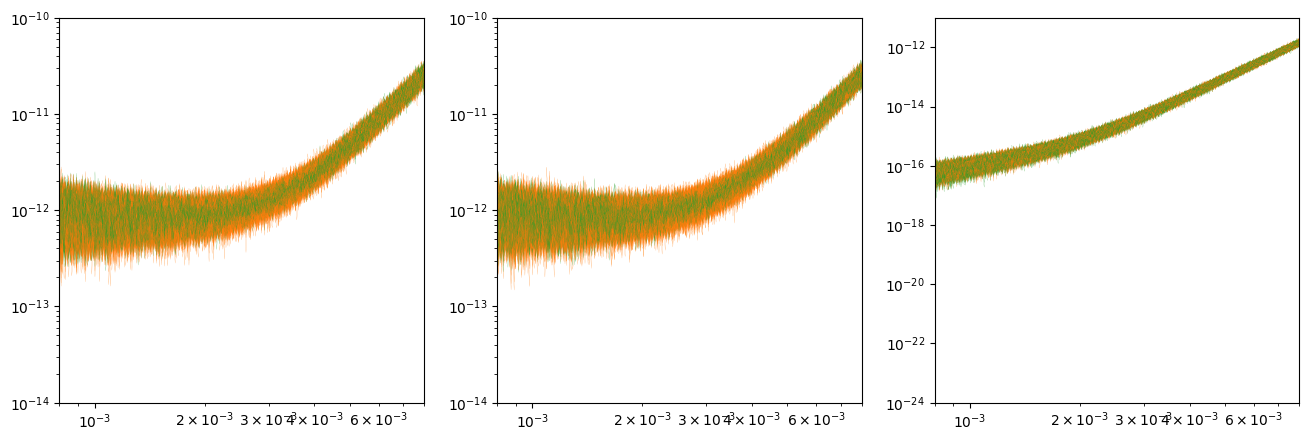

In [7]:
fig = plt.figure(figsize=(16, 5))
for _ in range(1000):
    data = dataset.sample(z=np.array([-11.0, 0.0, 3.0, 15.0]))
    for idx in range(3):
        ax = plt.subplot(1, 3, idx + 1)
        # plt.loglog(sim.coarse_grained_f, np.array(data['data'][:, idx]) * sim.cg_response_AET[:, idx], c='k', alpha=1.0, lw=0.1)
    data = dataset.sample(z=np.array([-11.0, 0.0, 0.0, 0.0]))
    for idx in range(3):
        ax = plt.subplot(1, 3, idx + 1)
        # plt.loglog(sim.coarse_grained_f, np.array(data['data'][:, idx]) * sim.cg_response_AET[:, idx], c='C0', alpha=1.0, lw=0.1)
    data = dataset.sample(z=np.array([-20.0, 0.0, 3.0, 15.0]))
    for idx in range(3):
        ax = plt.subplot(1, 3, idx + 1)
        plt.loglog(sim.coarse_grained_f, np.array(data['data'][:, idx]) * sim.cg_response_AET[:, idx], c='C1', alpha=1.0, lw=0.1)
    data = dataset.sample(z=np.array([-20.0, 0.0, 3.0, 15.0]), cross=0.0)
    for idx in range(3):
        ax = plt.subplot(1, 3, idx + 1)
        plt.loglog(sim.coarse_grained_f, np.array(data['data'][:, idx]) * sim.cg_response_AET[:, idx], c='C2', alpha=1.0, lw=0.1)
        plt.xlim(8e-4, 8e-3)
        if idx < 2: plt.ylim(1e-14, 1e-10)
        else: plt.ylim(1e-24, 1e-11)


In [6]:
mcmc_sim = LISA_AET(settings=saqqara.load_settings(config_path="../configs/bounded_mcmc.yaml"))

Detector setup complete


Noise matrices computed
Response computed
Coarse graining setup complete


In [47]:
sample = mcmc_sim.sample()

In [48]:
sample.keys()

dict_keys(['z', 'quadratic_signal_AET', 'linear_TM_noise_AET', 'linear_OMS_noise_AET', 'quadratic_noise_AET', 'quadratic_data_AET', 'coarse_grained_data'])

In [49]:
sample['quadratic_data_AET'].shape

(499971, 3)

In [50]:
mcmc_sim.response_AET

array([[4.39672166e-11, 4.39575018e-11, 3.65398762e-31],
       [5.01291898e-11, 5.01181125e-11, 5.07190868e-31],
       [5.69172328e-11, 5.69046543e-11, 6.96713510e-31],
       ...,
       [9.01772535e+00, 9.03327024e+00, 5.86257685e+00],
       [9.01835870e+00, 9.03390450e+00, 5.86334719e+00],
       [9.01899203e+00, 9.03453874e+00, 5.86411756e+00]])

In [51]:
mcmc_sim.TM_noise_matrix([3., 15.]).shape

(499971, 3, 3)

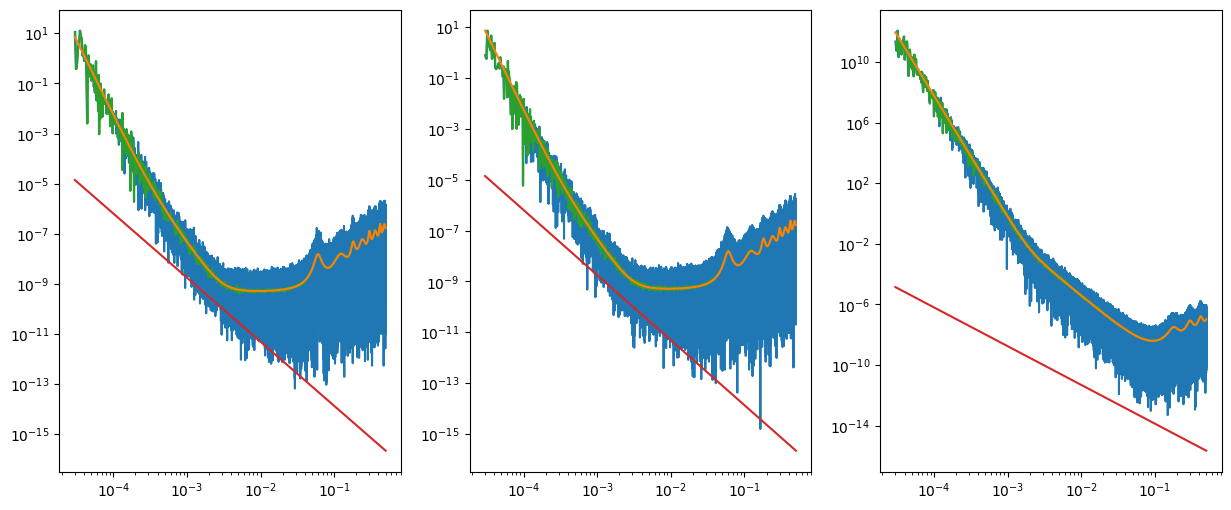

In [52]:
sample = mcmc_sim.sample()
z_sgwb, z_noise = sample['z'][:2], sample['z'][-2:]
fig = plt.figure(figsize=(15, 6))
for channel in range(3):
    ax = plt.subplot(1, 3, channel+1)
    plt.loglog(mcmc_sim.f_vec, sample['quadratic_data_AET'][:, channel] / mcmc_sim.response_AET[:, channel])
    plt.loglog(mcmc_sim.f_vec, (mcmc_sim.TM_noise_matrix(z_noise)[:, channel, channel] + mcmc_sim.OMS_noise_matrix(z_noise)[:, channel, channel])/ mcmc_sim.response_AET[:, channel] + mcmc_sim.sgwb_template(mcmc_sim.f_vec, z_sgwb), zorder=10)
    plt.loglog(mcmc_sim.coarse_grained_f, sample['coarse_grained_data'][:, channel])
    plt.loglog(mcmc_sim.f_vec, mcmc_sim.sgwb_template(mcmc_sim.f_vec, z_sgwb))

In [53]:
mcmc_sim.prior.bounds

array([[-12. , -10. ],
       [ -0.7,   0.7],
       [  0. ,   6. ],
       [  0. ,  30. ]])

In [7]:
class StatsModel:
    def __init__(self, simulator):
        self.sim = simulator
        self.Hubble_over_h = 3.24e-18
        self.Nbins = len(simulator.f_vec)
        self.TM_noise = jnp.abs(jnp.array(jnp.vstack([jnp.array(simulator.TM_tdi_matrix)[:, channel, channel] for channel in range(3)]).T / simulator.response_AET))
        self.OMS_noise = jnp.abs(jnp.array(jnp.vstack([jnp.array(simulator.OMS_tdi_matrix)[:, channel, channel] for channel in range(3)]).T / simulator.response_AET))
        self.f_vec = jnp.array(simulator.f_vec)

    def get_sample(self):
        return self.sim.sample()
    
    def get_quad_data(self, sample):
        return jnp.abs(sample['full_quadratic_data_AET'] / self.sim.response_AET)
    
    @partial(jax.jit, static_argnums=(0,))
    def sgwb_template(self, z_sgwb):
        conversion = 4 * jnp.pi**2 * self.f_vec**3 / 3 / self.sim.Hubble_over_h**2
        return jnp.abs(jnp.array(
            self.sim.overall_rescaling
            * 10 ** z_sgwb[0]
            * (self.f_vec / jnp.sqrt(self.f_vec [0] * self.f_vec [-1])) ** z_sgwb[1]
            / conversion
        ))
    
    @partial(jax.jit, static_argnums=(0,))
    def get_variance(self, z):
        z_sgwb, z_noise = z[:2], z[-2:]
        return z_noise[0]**2 * self.TM_noise + z_noise[1]**2 * self.OMS_noise + self.sgwb_template(z_sgwb)[:, None]
    
    @partial(jax.jit, static_argnums=(0,))
    def logL(self, z, quadratic_data_over_response, N_segments=1, channels=[0, 1, 2]):
        variance = self.get_variance(z)
        logL_array = -(jnp.log(variance[:, channels]) + quadratic_data_over_response[:, channels] / (variance[:, channels]))
        return N_segments * jnp.sum(logL_array)

    def log_prior(self, z):
        if not np.all(np.logical_and(z > self.sim.prior.bounds[:, 0], z < self.sim.prior.bounds[:, 1])):
            return -jnp.inf
        return 0

    def log_posterior(self, z, data, N_segments=1, channels=[0, 1, 2]):
        if jnp.isinf(self.log_prior(z)):
            return -jnp.inf
        return self.logL(z, data, N_segments, channels) + self.log_prior(z)

In [8]:
class GPTModel:
    def __init__(self, simulator):
        self.sim = simulator
        self.Hubble_over_h = 3.24e-18
        self.Nbins = len(simulator.f_vec)
        self.response_AET = jnp.array(simulator.response_AET)
        self.TM_noise = jnp.abs(jnp.array(jnp.vstack([simulator.TM_tdi_matrix[:, channel, channel] for channel in range(3)]).T) / self.response_AET)
        self.OMS_noise = jnp.abs(jnp.array(jnp.vstack([simulator.OMS_tdi_matrix[:, channel, channel] for channel in range(3)]).T) / self.response_AET)
        self.f_vec = jnp.array(simulator.f_vec)
        self.f_vec_cubed = self.f_vec ** 3
        self.conversion_factor = 4 * jnp.pi ** 2 / 3 / self.Hubble_over_h ** 2

    def get_sample(self):
        return self.sim.sample()
    
    def get_quad_data(self, sample):
        return jnp.abs(sample['full_quadratic_data_AET'] / self.response_AET)
    
    @partial(jax.jit, static_argnums=(0,))
    def sgwb_template(self, z_sgwb):
        power_term = (self.f_vec / jnp.sqrt(self.f_vec[0] * self.f_vec[-1])) ** z_sgwb[1]
        template = self.sim.overall_rescaling * 10 ** z_sgwb[0] * power_term / self.conversion_factor
        return jnp.abs(template / self.f_vec_cubed)

    @partial(jax.jit, static_argnums=(0,))
    def get_variance(self, z):
        z_sgwb, z_noise = z[:2], z[-2:]
        sgwb_temp = self.sgwb_template(z_sgwb)[:, None]
        tm_component = z_noise[0] ** 2 * self.TM_noise
        oms_component = z_noise[1] ** 2 * self.OMS_noise
        return tm_component + oms_component + sgwb_temp
    
    @partial(jax.jit, static_argnums=(0,))
    def logL(self, z, quadratic_data_over_response, N_segments=1, channels=[0, 1, 2]):
        variance = self.get_variance(z)
        logL_array = -(jnp.log(variance[:, channels]) + quadratic_data_over_response[:, channels] / variance[:, channels])
        return N_segments * jnp.sum(logL_array)

    def log_prior(self, z):
        if not np.all(np.logical_and(z > self.sim.prior.bounds[:, 0], z < self.sim.prior.bounds[:, 1])):
            return -jnp.inf
        return 0

    def log_posterior(self, z, data, N_segments=1, channels=[0, 1, 2]):
        prior_val = self.log_prior(z)
        if jnp.isinf(prior_val):
            return -jnp.inf
        logL_val = self.logL(z, data, N_segments, channels)
        return logL_val + prior_val

In [15]:
class GPTModel2:
    def __init__(self, simulator):
        self.sim = simulator
        self.Hubble_over_h = 3.24e-18
        self.Nbins = len(simulator.f_vec)
        self.response_AET = jnp.array(simulator.response_AET)
        self.TM_noise = jnp.abs(jnp.array(jnp.vstack([simulator.TM_tdi_matrix[:, channel, channel] for channel in range(3)]).T) / self.response_AET)
        self.OMS_noise = jnp.abs(jnp.array(jnp.vstack([simulator.OMS_tdi_matrix[:, channel, channel] for channel in range(3)]).T) / self.response_AET)
        self.f_vec = jnp.array(simulator.f_vec)
        self.f_vec_cubed = self.f_vec ** 3
        self.conversion_factor = 4 * jnp.pi ** 2 / 3 / self.Hubble_over_h ** 2
        self.prior_bounds = jnp.array(simulator.prior.bounds)

    def get_sample(self):
        return self.sim.sample()
    
    def get_quad_data(self, sample):
        return jnp.abs(sample['full_quadratic_data_AET'] / self.response_AET)
    
    @partial(jax.jit, static_argnums=(0,))
    def sgwb_template(self, z_sgwb):
        power_term = (self.f_vec / jnp.sqrt(self.f_vec[0] * self.f_vec[-1])) ** z_sgwb[1]
        template = self.sim.overall_rescaling * 10 ** z_sgwb[0] * power_term / self.conversion_factor
        return jnp.abs(template / self.f_vec_cubed)

    @partial(jax.jit, static_argnums=(0,))
    def get_variance(self, z):
        z_sgwb, z_noise = z[:2], z[-2:]
        sgwb_temp = self.sgwb_template(z_sgwb)[:, None]
        tm_component = z_noise[0] ** 2 * self.TM_noise
        oms_component = z_noise[1] ** 2 * self.OMS_noise
        return tm_component + oms_component + sgwb_temp
    
    @partial(jax.jit, static_argnums=(0,))
    def logL(self, z, quadratic_data_over_response, N_segments=1, channels=(0, 1, 2)):
        variance = self.get_variance(z)
        logL_array = -(jnp.log(variance[:, channels]) + quadratic_data_over_response[:, channels] / variance[:, channels])
        return N_segments * jnp.sum(logL_array)
    
    @partial(jax.jit, static_argnums=(0,))
    def log_prior(self, z):
        in_bounds = jnp.all((z > self.prior_bounds[:, 0]) & (z < self.prior_bounds[:, 1]))
        return jnp.where(in_bounds, 0.0, -jnp.inf)

    @partial(jax.jit, static_argnums=(0,))
    def log_posterior(self, z, data, N_segments=1, channels=(0, 1, 2)):
        prior_val = self.log_prior(z)
        logL_val = self.logL(z, data, N_segments, channels)
        return jnp.where(jnp.isinf(prior_val), -jnp.inf, logL_val + prior_val)

In [16]:
st = StatsModel(mcmc_sim)
gpt = GPTModel(mcmc_sim)
gpt2 = GPTModel2(mcmc_sim)

In [17]:
data = mcmc_sim.sample()
quad_data = gpt.get_quad_data(data)

In [21]:
%time st.logL(jnp.array([-11.0, 0.0, 3.0, 15.0]), quad_data)
%time gpt.logL(jnp.array([-11.0, 0.0, 3.0, 15.0]), quad_data)
%time gpt2.logL(jnp.array([-11.0, 0.0, 3.0, 15.0]), quad_data)

CPU times: user 33.2 ms, sys: 315 µs, total: 33.5 ms
Wall time: 13.6 ms
CPU times: user 34 ms, sys: 0 ns, total: 34 ms
Wall time: 14.1 ms
CPU times: user 28.6 ms, sys: 0 ns, total: 28.6 ms
Wall time: 10.8 ms


Array(25272246.14120771, dtype=float64)

In [12]:
%time st.logL(jnp.array([-11.0, 0.0, 3.0, 15.0]), quad_data)
%time gpt.logL(jnp.array([-11.0, 0.0, 3.0, 15.0]), quad_data)

CPU times: user 34.7 ms, sys: 247 µs, total: 34.9 ms
Wall time: 14.8 ms
CPU times: user 30.9 ms, sys: 269 µs, total: 31.2 ms
Wall time: 11.8 ms


Array(23193060.32360814, dtype=float64)

In [25]:
%time st.log_posterior(jnp.array([-11.0, 0.0, 3.0, 15.0]), quad_data)
%time gpt.log_posterior(jnp.array([-11.0, 0.0, 3.0, 15.0]), quad_data)
%time gpt2.log_posterior(jnp.array([-11.0, 0.0, 3.0, 15.0]), quad_data)

CPU times: user 39.2 ms, sys: 0 ns, total: 39.2 ms
Wall time: 11.1 ms
CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 11.2 ms
CPU times: user 22.9 ms, sys: 2.87 ms, total: 25.8 ms
Wall time: 8.25 ms


Array(25272246.14120771, dtype=float64)

In [55]:
class JAModel:
    def __init__(self, simulator):
        self.sim = simulator
        self.Hubble_over_h = 3.24e-18
        self.Nbins = len(simulator.f_vec)
        self.TM_noise = jnp.abs(jnp.array(jnp.vstack([jnp.array(simulator.TM_tdi_matrix)[:, channel, channel] for channel in range(3)]).T / simulator.response_AET))
        self.OMS_noise = jnp.abs(jnp.array(jnp.vstack([jnp.array(simulator.OMS_tdi_matrix)[:, channel, channel] for channel in range(3)]).T / simulator.response_AET))
        self.f_vec = jnp.array(simulator.f_vec)

    def get_sample(self):
        return self.sim.sample()
    
    def get_quad_data(self, sample):
        return jnp.abs(sample['quadratic_data_AET'] / self.sim.response_AET)
    
    @partial(jax.jit, static_argnums=(0,))
    def sgwb_template(self, z_sgwb):
        conversion = 4 * jnp.pi**2 * self.f_vec**3 / 3 / self.sim.Hubble_over_h**2
        return jnp.abs(jnp.array(
            self.sim.overall_rescaling
            * 10 ** z_sgwb[0]
            * (self.f_vec / jnp.sqrt(self.f_vec [0] * self.f_vec [-1])) ** z_sgwb[1]
            / conversion
        ))
    
    @partial(jax.jit, static_argnums=(0,))
    def get_noise_variance(self, z):
        _, z_noise = z[:2], z[-2:]
        return z_noise[0]**2 * self.TM_noise + z_noise[1]**2 * self.OMS_noise
    
    @partial(jax.jit, static_argnums=(0,))
    def get_signal_variance(self, z):
        z_sgwb, _ = z[:2], z[-2:]
        return self.sgwb_template(z_sgwb)[:, None]
    
    @partial(jax.jit, static_argnums=(0,))
    def logL_analytic(self, Dj, sigma):
        return jnp.log(1.0 / (2.0 * jnp.abs(sigma[0] ** 2 - sigma[1] ** 2))) + jnp.log(
            jnp.abs(
                (
                    jnp.exp(-Dj / (2.0 * sigma[0] ** 2))
                    - jnp.exp(-Dj / (2.0 * sigma[1] ** 2))
                )
            )
        )

    @partial(jax.jit, static_argnums=(0,))
    def logL_limit(self, Dj, sigma):
        return jnp.log(Dj / (4.0 * sigma[0] ** 4)) - Dj / (2.0 * sigma[0] ** 2)

    @partial(jax.jit, static_argnums=(0,))
    def logL_bin(self, Dj, sigma):
        return jax.lax.cond(
            sigma[0] != sigma[1], self.logL_analytic, self.logL_limit, Dj, sigma
        )

    def logL_vm(self, Dj, sigma):
        return jax.vmap(self.logL_bin, in_axes=(0, 0))(Dj, sigma)
    
    @partial(jax.jit, static_argnums=(0,))
    def logL(self, z, quadratic_data_over_response, N_segments=1):
        logL = 0.0
        noise_variance = self.get_noise_variance(z)
        signal_variance = self.get_signal_variance(z)
        for channel in range(3):
            D = quadratic_data_over_response[:, channel] * 2. # Convention in data generation step (Re + Im) / sqrt(2)
            noise_sigma = jnp.sqrt(noise_variance[:, channel])
            signal_sigma = jnp.sqrt(signal_variance[:, 0])
            sigma = jnp.vstack([noise_sigma, signal_sigma]).T
            logL_array = self.logL_vm(D, sigma)
            logL += jnp.sum(logL_array)
        return N_segments * logL

    def log_prior(self, z):
        if not np.all(np.logical_and(z > self.sim.prior.bounds[:, 0], z < self.sim.prior.bounds[:, 1])):
            return -jnp.inf
        return 0

    def log_posterior(self, z, data, N_segments=1):
        if jnp.isinf(self.log_prior(z)):
            return -jnp.inf
        return self.logL(z, data, N_segments) + self.log_prior(z)

In [111]:
class ThreeChannel:
    def __init__(self, simulator):
        self.sim = simulator
        self.Hubble_over_h = 3.24e-18
        self.Nbins = len(simulator.f_vec)
        self.TM_noise = jnp.abs(jnp.array(jnp.vstack([jnp.array(simulator.TM_tdi_matrix)[:, channel, channel] for channel in range(3)]).T / simulator.response_AET))
        self.OMS_noise = jnp.abs(jnp.array(jnp.vstack([jnp.array(simulator.OMS_tdi_matrix)[:, channel, channel] for channel in range(3)]).T / simulator.response_AET))
        self.f_vec = jnp.array(simulator.f_vec)

    def get_sample(self):
        return self.sim.sample()
    
    def get_quad_data(self, sample):
        return jnp.abs(sample['quadratic_data_AET'] / self.sim.response_AET)
    
    @partial(jax.jit, static_argnums=(0,))
    def sgwb_template(self, z_sgwb):
        conversion = 4 * jnp.pi**2 * self.f_vec**3 / 3 / self.sim.Hubble_over_h**2
        return jnp.abs(jnp.array(
            self.sim.overall_rescaling
            * 10 ** z_sgwb[0]
            * (self.f_vec / jnp.sqrt(self.f_vec [0] * self.f_vec [-1])) ** z_sgwb[1]
            / conversion
        ))
    
    @partial(jax.jit, static_argnums=(0,))
    def get_noise_variance(self, z):
        _, z_noise = z[:2], z[-2:]
        return z_noise[0]**2 * self.TM_noise + z_noise[1]**2 * self.OMS_noise
    
    @partial(jax.jit, static_argnums=(0,))
    def get_signal_variance(self, z):
        z_sgwb, _ = z[:2], z[-2:]
        return self.sgwb_template(z_sgwb)[:, None]
    
    @partial(jax.jit, static_argnums=(0,))
    def logL_analytic(self, Dj, sigma):
        sigmaA, sigmaE, sigmaT, sigmaS = sigma[0], sigma[1], sigma[2], sigma[3]
        DA, DE, DT = Dj[0], Dj[1], Dj[2]
        logL = -(
            (0.5 * DA / sigmaA**2)
            + (0.5 * DE / sigmaE**2)
            + (0.5 * DT / sigmaT**2)
            + jnp.log(16.0)
            + jnp.log(sigmaS**2)
            + jnp.log(sigmaA**2)
            + jnp.log(sigmaE**2)
            + jnp.log(sigmaT**2)
            + jnp.log(
                jnp.abs(
                    0.5 / sigmaA**2 + 0.5 / sigmaE**2 + 0.5 / sigmaT**2 - 0.5 / sigmaS**2
                )
            )
            - jnp.log(
                jnp.abs(
                    jnp.exp((0.5 / sigmaA**2 + 0.5 / sigmaE**2 + 0.5 / sigmaT**2 - 0.5 / sigmaS**2) * jnp.min(jnp.array([DA, DE, DT]))) - 1.0
                )
            )
        )
        return logL

    def logL_vm(self, Dj, sigma):
        return jax.vmap(self.logL_analytic, in_axes=(0, 0))(Dj, sigma)
    
    @partial(jax.jit, static_argnums=(0,))
    def logL(self, z, quadratic_data_over_response, N_segments=1):
        logL = 0.0
        noise_variance = self.get_noise_variance(z)
        signal_variance = self.get_signal_variance(z)
        sigma = jnp.sqrt(jnp.hstack([noise_variance, signal_variance])) # (A, E, T, S)
        D = 2. * quadratic_data_over_response
        logL_array = self.logL_vm(D, sigma)
        return N_segments * jnp.sum(logL_array)

    def log_prior(self, z):
        if not np.all(np.logical_and(z > self.sim.prior.bounds[:, 0], z < self.sim.prior.bounds[:, 1])):
            return -jnp.inf
        return 0

    def log_posterior(self, z, data, N_segments=1):
        if jnp.isinf(self.log_prior(z)):
            return -jnp.inf
        return self.logL(z, data, N_segments) + self.log_prior(z)

In [97]:
three_channel = ThreeChannel(mcmc_sim)

In [148]:
noise_variance = ja_model.get_noise_variance(jnp.array([-11.0, 0.0, 3.0, 15.0]))
signal_variance = ja_model.get_signal_variance(jnp.array([-11.0, 0.0, 3.0, 15.0]))

In [86]:
jnp.hstack([noise_variance, signal_variance]).shape

(499971, 4)

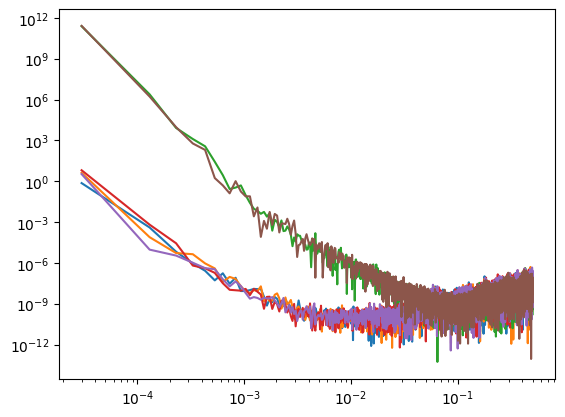

In [180]:
n = (np.random.normal(0., np.sqrt(noise_variance)) + 1j * np.random.normal(0., np.sqrt(noise_variance))) / np.sqrt(2)
s = (np.random.normal(0., np.sqrt(signal_variance)) + 1j * np.random.normal(0., np.sqrt(signal_variance))) / np.sqrt(2)
data = np.abs(n)**2 + np.abs(s)**2
stats.get_quad_data(stats.sim.sample())
plt.loglog(stats.sim.f_vec, data)
plt.loglog(stats.sim.f_vec, stats.get_quad_data(stats.sim.sample()))

In [109]:
stats = StatsModel(mcmc_sim)

In [163]:
ja_model = JAModel(mcmc_sim)
stats = StatsModel(mcmc_sim)
three_channel = ThreeChannel(mcmc_sim)

In [57]:
noise_variance = ja_model.get_noise_variance(jnp.array([-11.0, 0.0, 3.0, 15.0]))
signal_variance = ja_model.get_signal_variance(jnp.array([-11.0, 0.0, 3.0, 15.0]))
for channel in range(3):
    noise_sigma = jnp.sqrt(noise_variance[:, channel])
    signal_sigma = jnp.sqrt(signal_variance[:, 0])
    sigma = jnp.vstack([noise_sigma, signal_sigma]).T
    print(sigma.shape)

(499971, 2)
(499971, 2)
(499971, 2)


In [27]:
stats = StatsModel(mcmc_sim)

In [9]:
tm_var = 3.**2 * stats.TM_noise
oms_var = 15.**2 * stats.OMS_noise
sgwb_var = stats.sgwb_template(jnp.array([-11.0, 0.]))[:, None]

In [10]:
tm_linear_data = jnp.array(np.random.normal(0, np.sqrt(tm_var)) + 1j * np.random.normal(0, np.sqrt(tm_var))) / np.sqrt(2)
oms_linear_data = jnp.array(np.random.normal(0, np.sqrt(oms_var)) + 1j * np.random.normal(0, np.sqrt(oms_var))) / np.sqrt(2)
sgwb_linear_data = jnp.array(np.random.normal(0, np.sqrt(sgwb_var)) + 1j * np.random.normal(0, np.sqrt(sgwb_var))) / np.sqrt(2)
full_linear_data = tm_linear_data + oms_linear_data + sgwb_linear_data
complete_data = jnp.array(jnp.abs(full_linear_data) ** 2)
restricted_data = jnp.array(jnp.abs(tm_linear_data + oms_linear_data)**2 + jnp.abs(sgwb_linear_data)**2)

In [11]:
test_data = jnp.array(stats.get_quad_data(stats.get_sample()))

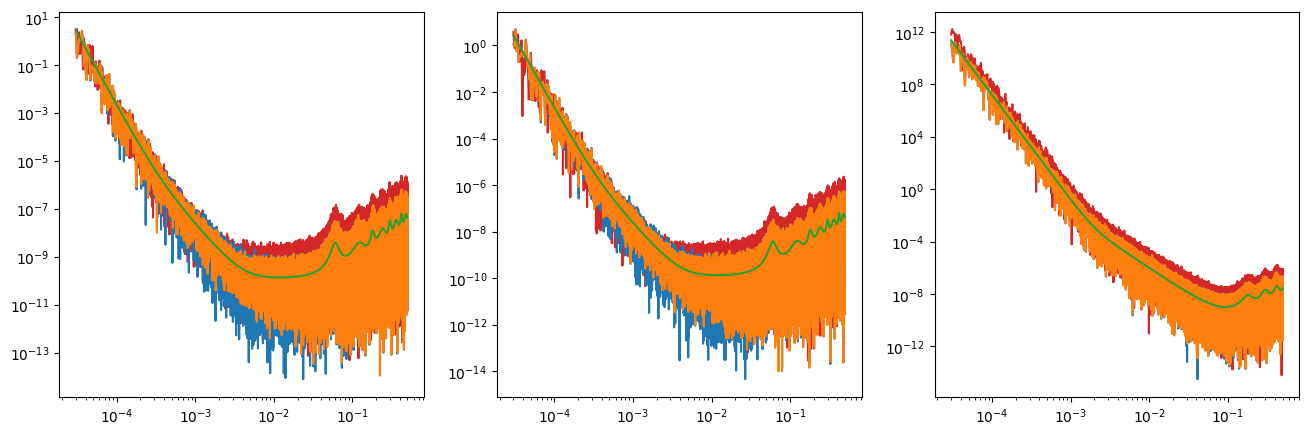

In [12]:
fig = plt.figure(figsize=(16, 5))
for idx in range(3):
    ax = plt.subplot(1, 3, idx + 1)
    plt.loglog(mcmc_sim.f_vec, complete_data[:, idx])
    plt.loglog(mcmc_sim.f_vec, restricted_data[:, idx])
    plt.loglog(mcmc_sim.f_vec, tm_var[:, idx] + oms_var[:, idx] + sgwb_var[:, 0])
    plt.loglog(mcmc_sim.f_vec, test_data[:, idx], zorder=-10)


In [14]:
stats = StatsModel(mcmc_sim)

In [74]:
%time stats.get_variance(jnp.array([-11.0, 0.0, 3., 15.]))

CPU times: user 13.6 ms, sys: 637 µs, total: 14.2 ms
Wall time: 3.54 ms


Array([[2.71718483e+00, 2.71778527e+00, 2.34687003e+11],
       [2.23291140e+00, 2.23340487e+00, 1.80536763e+11],
       [1.84647399e+00, 1.84688209e+00, 1.40042388e+11],
       ...,
       [4.23460864e-08, 4.22732152e-08, 2.67522880e-08],
       [4.23449321e-08, 4.22720638e-08, 2.67528251e-08],
       [4.23437779e-08, 4.22709123e-08, 2.67533622e-08]], dtype=float64)

In [110]:
data = jnp.array(stats.get_quad_data(stats.get_sample()))

In [115]:
%time stats.logL(jnp.array([-11.0, 0.0, 3., 15.]), data, channels=[0, 1, 2])

CPU times: user 548 ms, sys: 60.1 ms, total: 608 ms
Wall time: 553 ms


Array(27074469.7939926, dtype=float64)

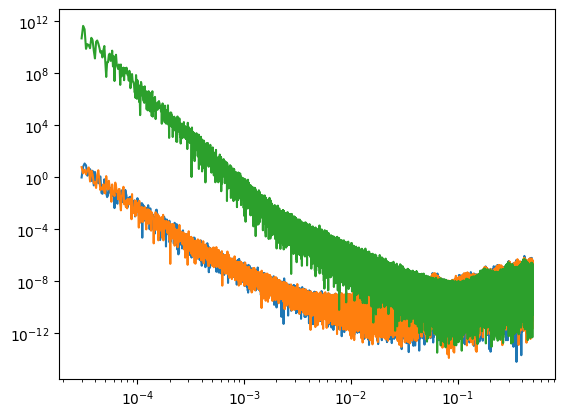

In [79]:
plt.loglog(stats.sim.f_vec, stats.get_quad_data(stats.get_sample()))

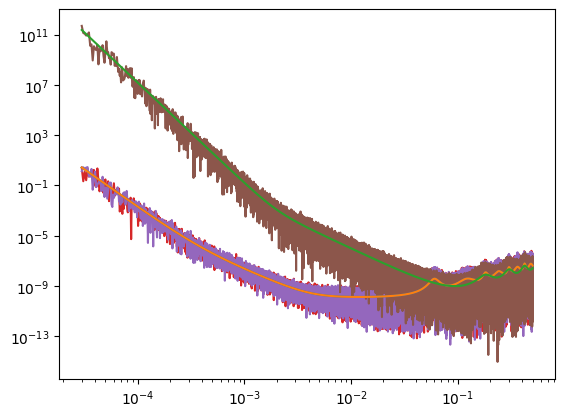

In [125]:
plt.loglog(stats.sim.f_vec, stats.get_variance(z=np.array([-11.0, 0.0, 3.0, 15.0])), zorder=10)
plt.loglog(stats.sim.f_vec, stats.get_quad_data(stats.sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})))

In [81]:
stats.logL(jnp.array([-11.0, 0.0, 3.0, 15.0]), stats.get_quad_data(stats.sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})))

Array(26302687.12553622, dtype=float64)

In [117]:
stats.log_posterior(np.array([-11., 0.0, 3.0, 15.0]), stats.get_quad_data(stats.sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})), channels=[0,2])

Array(17493652.31088934, dtype=float64)

In [26]:
def mcmc(stats, data, nwalkers=100, nsteps=1000, Nsegs=1, channels=[0, 1, 2]):
    ndim = 4
    p0 = stats.sim.prior.sample(nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, stats.log_posterior, args=[data, Nsegs, channels])
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler

In [28]:
data_sample = sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})
data = st.get_quad_data(data_sample)

In [18]:
stats_sampler = mcmc(stats, data, nwalkers=100, nsteps=1000, channels=[0, 1, 2])

100%|██████████| 1000/1000 [22:29<00:00,  1.35s/it]


In [29]:
%time sampler = mcmc(st, data, nwalkers=100, nsteps=20, channels=[0, 1, 2])
%time sampler = mcmc(gpt, data, nwalkers=100, nsteps=20, channels=[0, 1, 2])
%time sampler = mcmc(gpt2, data, nwalkers=100, nsteps=20, channels=[0, 1, 2])

100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


CPU times: user 1min 19s, sys: 73.7 ms, total: 1min 19s
Wall time: 22.7 s


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


CPU times: user 1min 21s, sys: 150 ms, total: 1min 21s
Wall time: 23.4 s


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

CPU times: user 1min 37s, sys: 256 ms, total: 1min 37s
Wall time: 27.6 s


In [124]:
A_stats_sampler = mcmc(stats, data, nwalkers=100, nsteps=1000, channels=[0,])

100%|██████████| 1000/1000 [12:11<00:00,  1.37it/s]


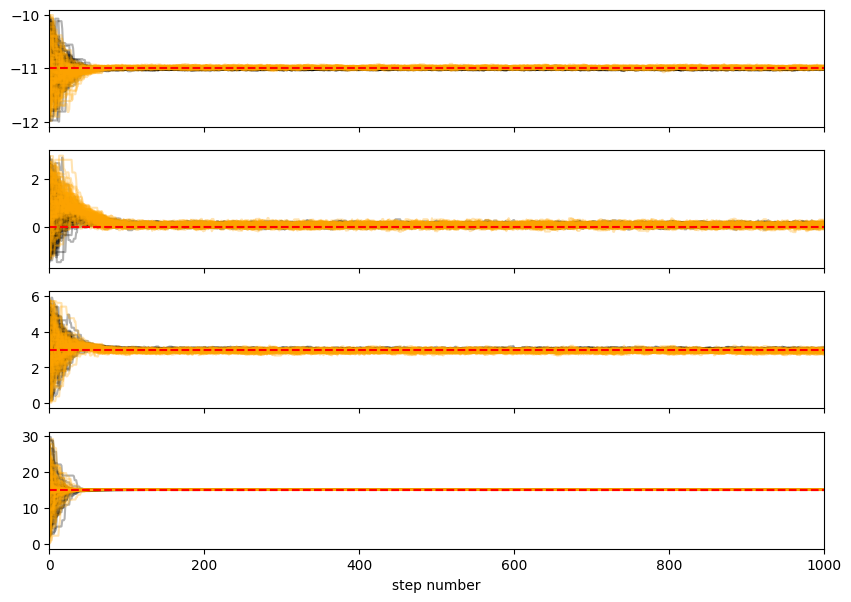

In [125]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = AA_stats_sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

samples = A_stats_sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "orange", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

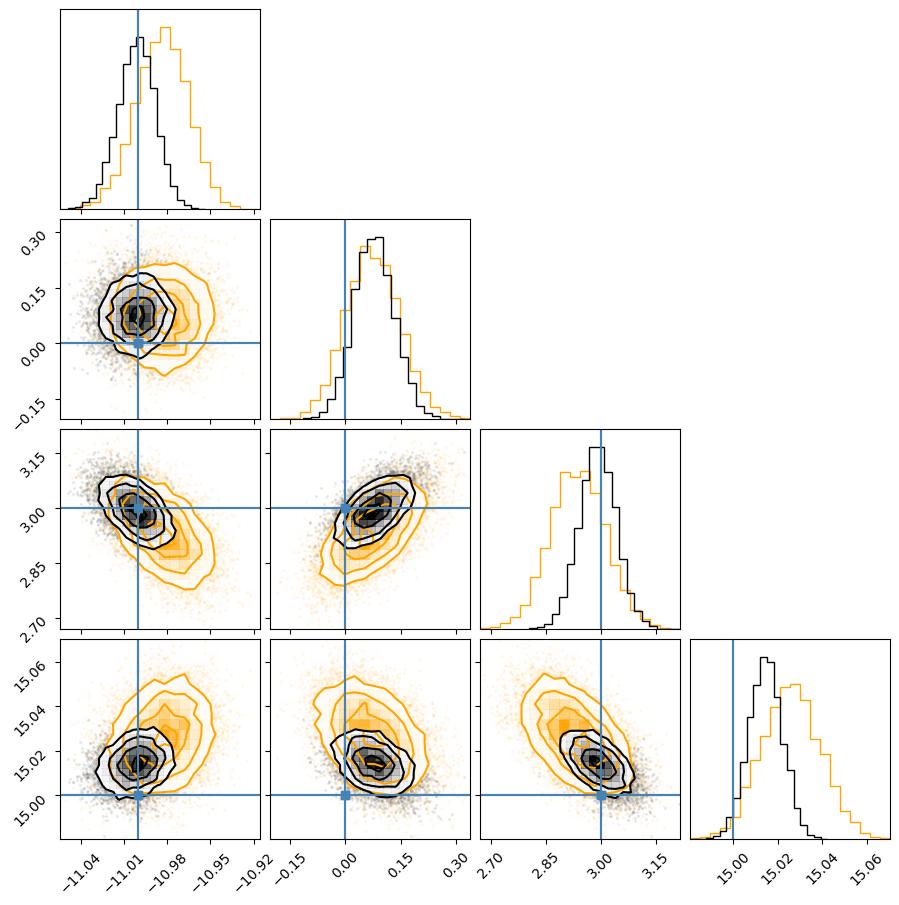

In [127]:
import corner

fig = corner.corner(
    A_stats_sampler.get_chain(discard=100, thin=10, flat=True), truths=data_sample['z'], color='orange'
)
fig = corner.corner(
    AA_stats_sampler.get_chain(discard=100, thin=10, flat=True), truths=data_sample['z'], fig=plt.gcf()
)

In [195]:
ja_sampler = mcmc(ja_model, data, nwalkers=100, nsteps=1000)

100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


In [137]:
three_channel.sim.prior.bounds

array([[-12. , -10. ],
       [ -1.5,   3. ],
       [  0. ,   6. ],
       [  0. ,  30. ]])

In [183]:
three_channel.sim.prior.bounds = np.array([[-12., -10.], [-1.5, 3.0], [1., 6.], [12., 18.]])
three_sampler = mcmc(three_channel, data, nwalkers=100, nsteps=1000)

100%|██████████| 1000/1000 [00:39<00:00, 25.14it/s]


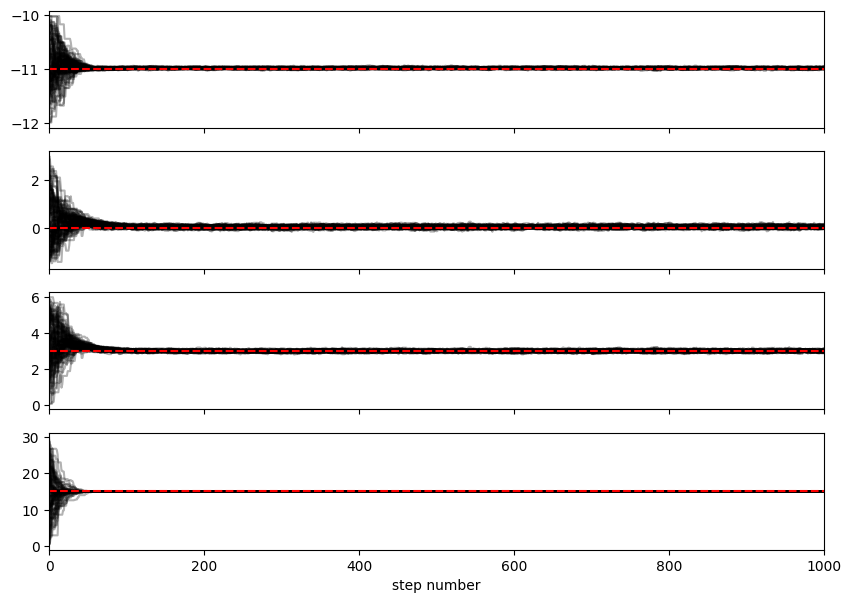

In [19]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = stats_sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

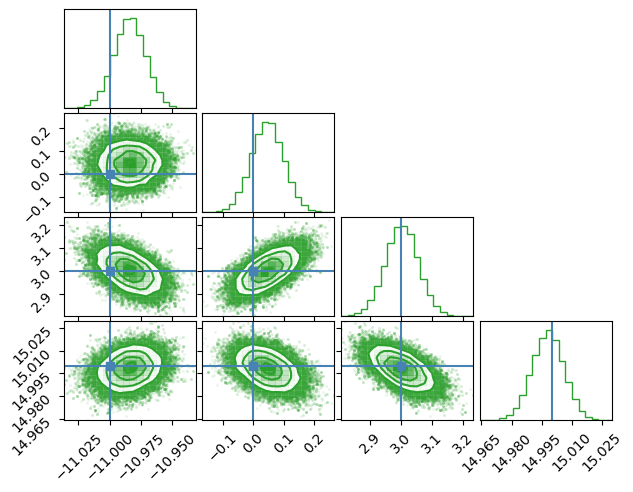

In [20]:
import corner
fig = corner.corner(
    stats_sampler.get_chain(discard=100, thin=1, flat=True), color="C2", truths=[-11.0, 0.0, 3.0, 15.0], fig=plt.gcf()
)

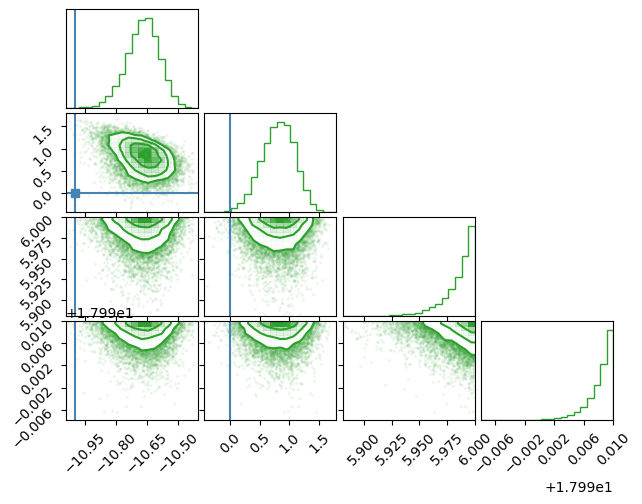

In [166]:
fig = corner.corner(
    three_sampler.get_chain(discard=2000, thin=20, flat=True), color="C2", truths=[-11.0, 0.0, 3.0, 15.0], fig=plt.gcf()
)

In [189]:
from getdist import plots, MCSamples
import getdist

Removed no burn in
Removed no burn in
Removed no burn in


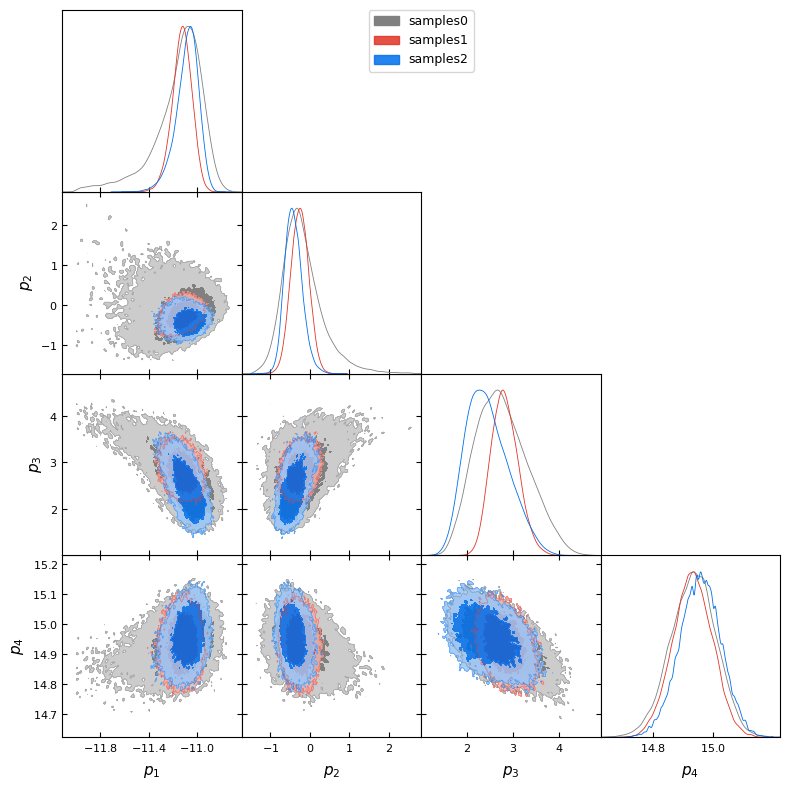

In [196]:
%matplotlib inline
stats_samples = MCSamples(samples=stats_sampler.get_chain(discard=100, thin=1, flat=True))
three_samples = MCSamples(samples=three_sampler.get_chain(discard=100, thin=1, flat=True))
ja_samples = MCSamples(samples=ja_sampler.get_chain(discard=100, thin=1, flat=True))
g = plots.get_subplot_plotter()
g.triangle_plot([stats_samples, three_samples, ja_samples], filled=True)

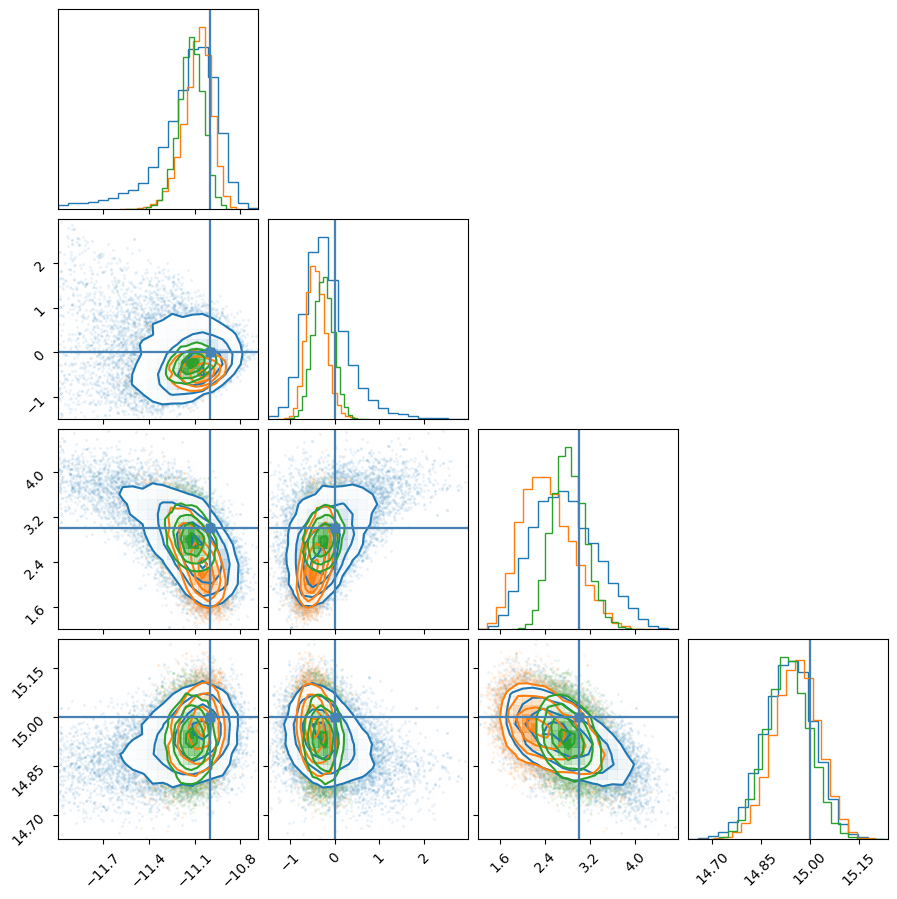

In [198]:
import corner

fig = corner.corner(
    stats_sampler.get_chain(discard=100, thin=5, flat=True), color="C0", truths=[-11.0, 0.0, 3.0, 15.0], plot_density=True
)
fig = corner.corner(
    ja_sampler.get_chain(discard=100, thin=5, flat=True), color="C1", truths=[-11.0, 0.0, 3.0, 15.0], fig=plt.gcf()
)
fig = corner.corner(
    three_sampler.get_chain(discard=100, thin=5, flat=True), color="C2", truths=[-11.0, 0.0, 3.0, 15.0], fig=plt.gcf(), plot_density=True
)

In [71]:
np.save('cg_data', data_sample['coarse_grained_data'])
np.save('mcmc_data', data)

In [65]:
np.save('chain', ja_sampler.get_chain(discard=100, thin=10, flat=True))

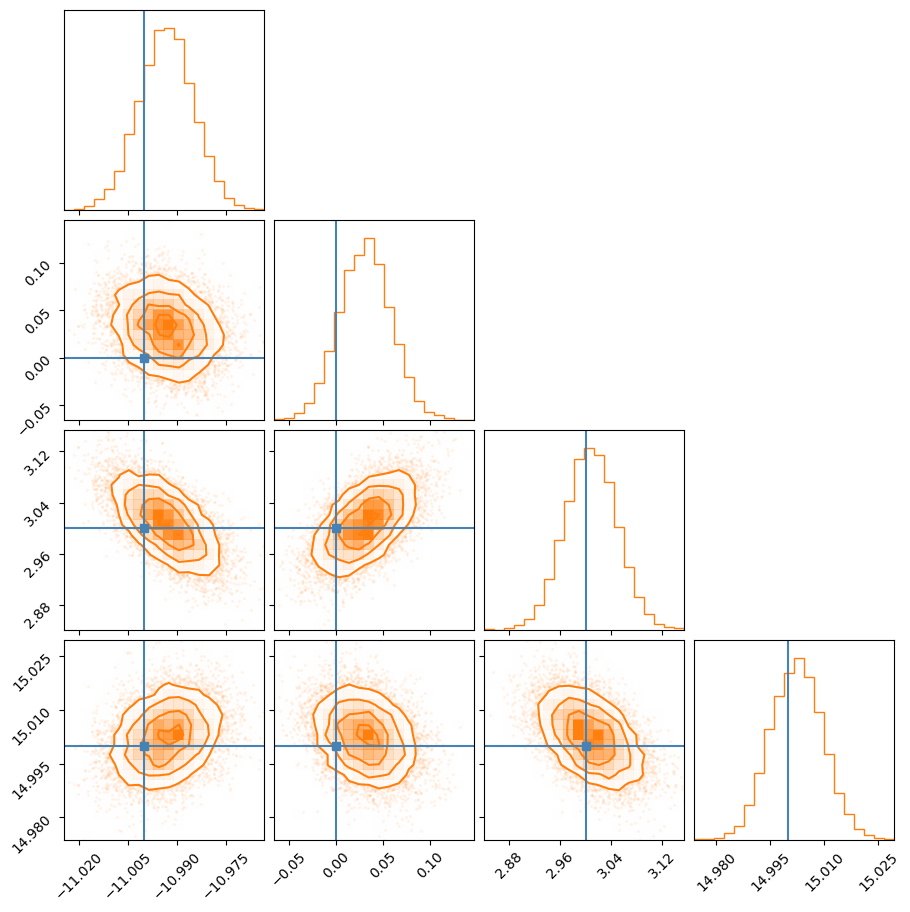

In [62]:
fig = corner.corner(
    ja_sampler.get_chain(discard=100, thin=10, flat=True), color="C1", truths=[-11.0, 0.0, 3.0, 15.0]
)

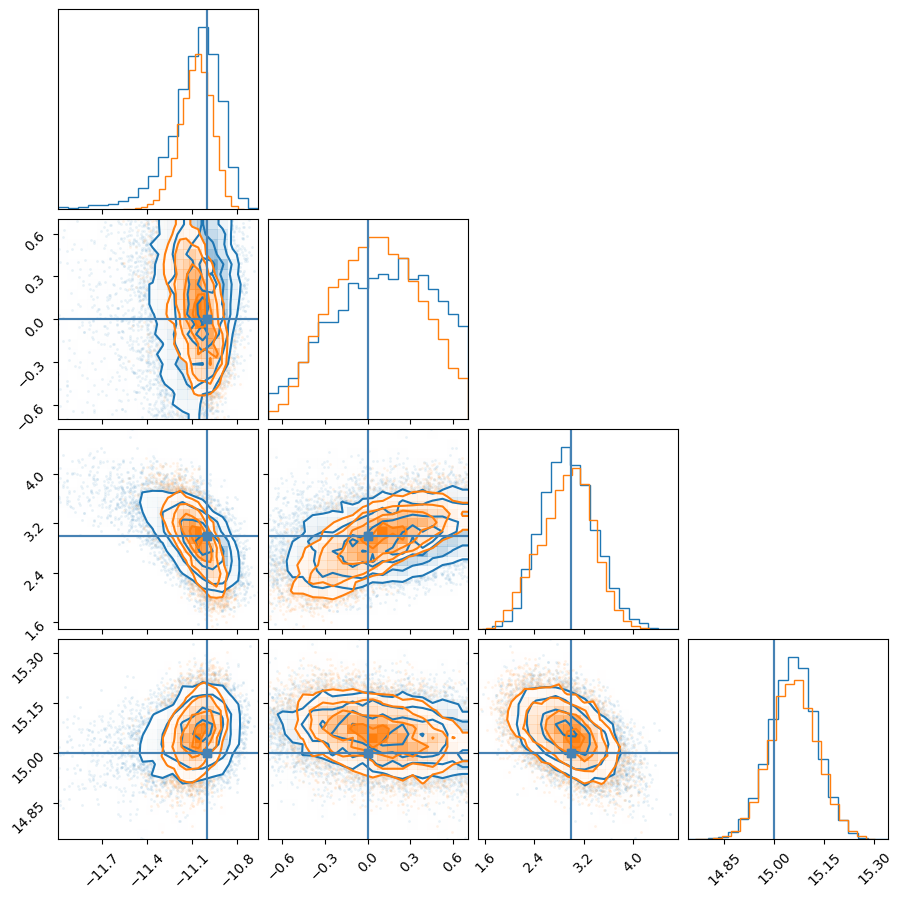

In [45]:
import corner

fig = corner.corner(
    complete_sampler.get_chain(discard=100, thin=10, flat=True), color="C0", truths=[-11.0, 0.0, 3.0, 15.0]
)

fig = corner.corner(
    ja_sampler.get_chain(discard=100, thin=10, flat=True), color="C1", truths=[-11.0, 0.0, 3.0, 15.0], fig=plt.gcf()
)

In [15]:
restricted_sampler = mcmc(stats, restricted_data, nwalkers=100, nsteps=1000)

100%|██████████| 1000/1000 [17:15<00:00,  1.04s/it]


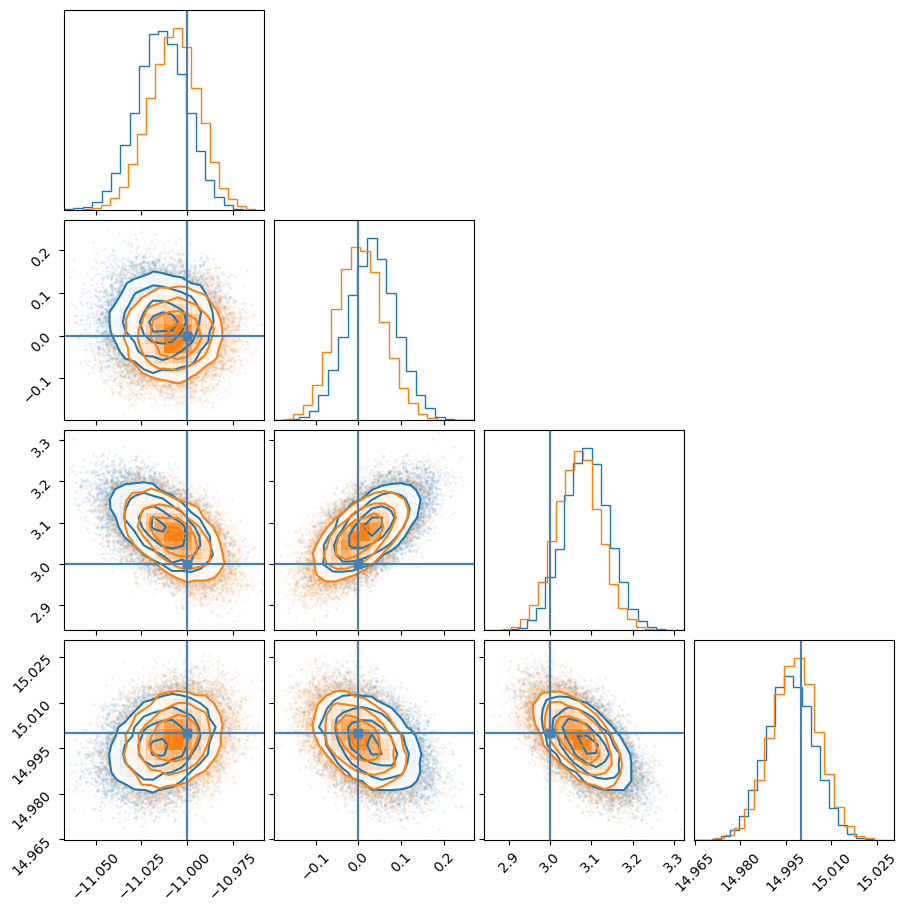

In [26]:
import corner

fig = corner.corner(
    complete_sampler.get_chain(discard=100, thin=5, flat=True), color="C0", truths=[-11.0, 0.0, 3.0, 15.0]
)
corner.corner(
    restricted_sampler.get_chain(discard=100, thin=5, flat=True), color="C1", truths=[-11.0, 0.0, 3.0, 15.0], fig=plt.gcf()
);

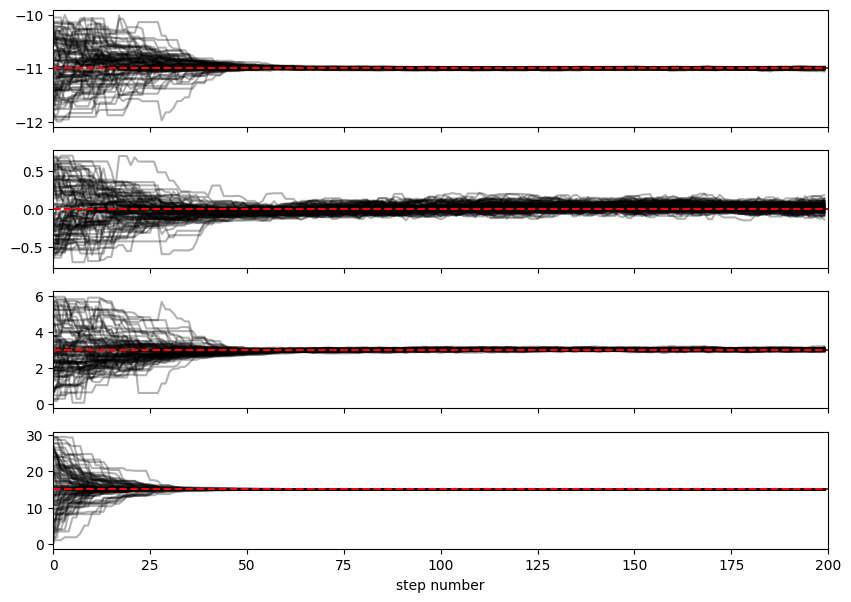

In [53]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = complete_sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

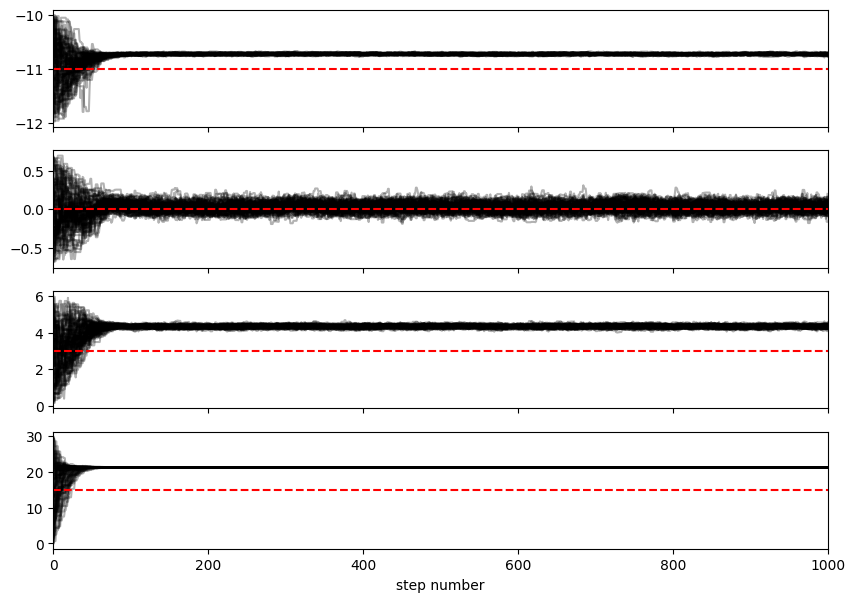

In [34]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = restricted_sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

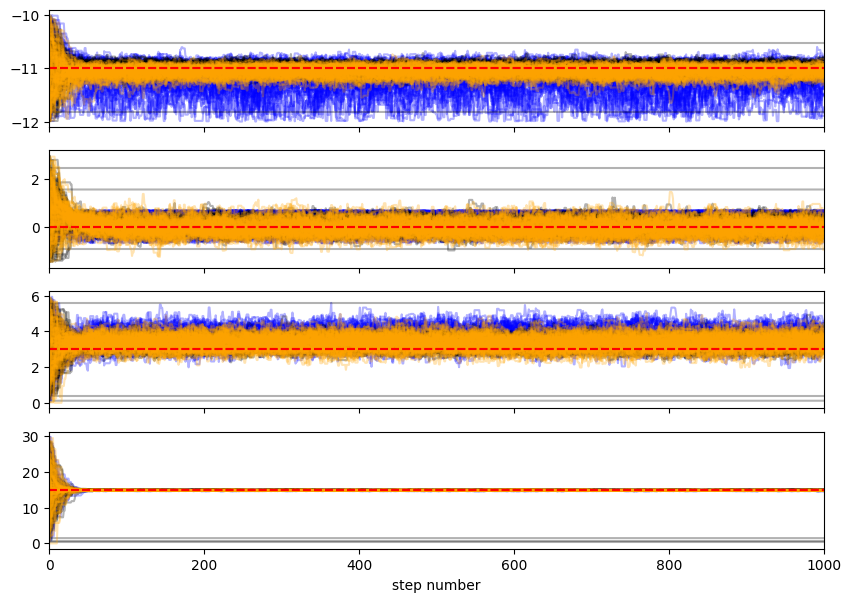

In [123]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = three_sampler.get_chain()
target_z = data_sample['z']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

samples = ja_sampler.get_chain()
target_z = data_sample['z']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "orange", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

samples = complete_sampler.get_chain()
target_z = data_sample['z']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "blue", alpha=0.3, zorder=-10)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

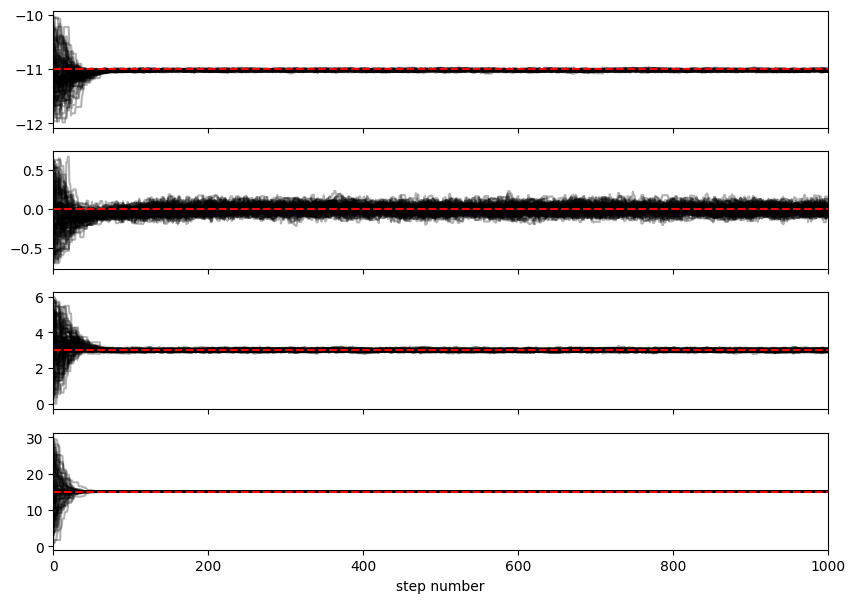

In [144]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = one_sampler.get_chain()
target_z = data_sample['z']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

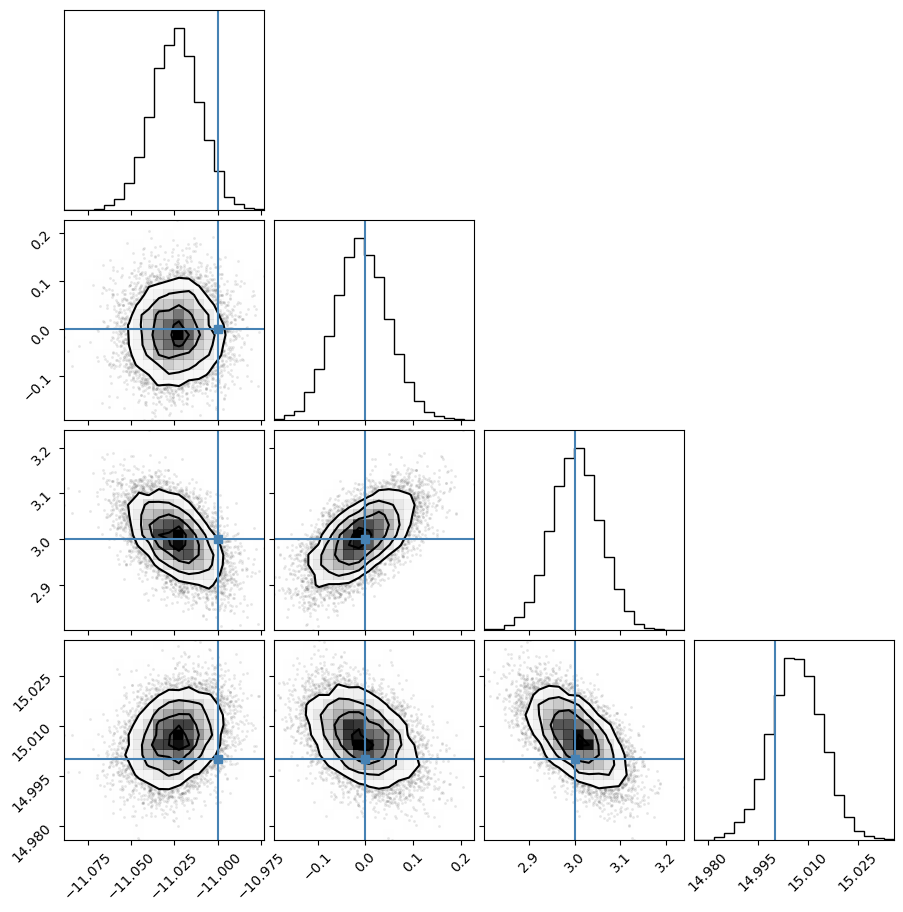

In [145]:
import corner

fig = corner.corner(
    one_sampler.get_chain(discard=100, thin=10, flat=True), truths=data_sample['z']
)

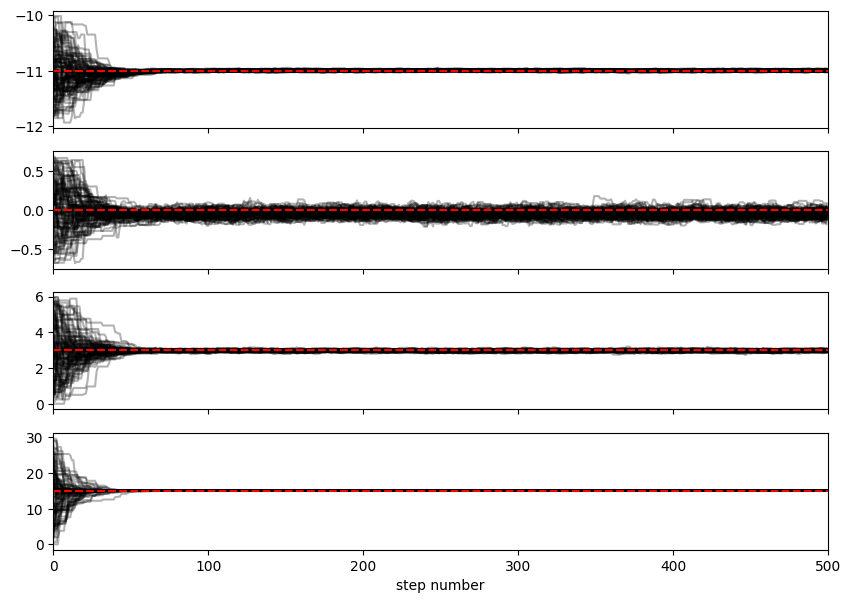

In [22]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
target_z = data_sample['z']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

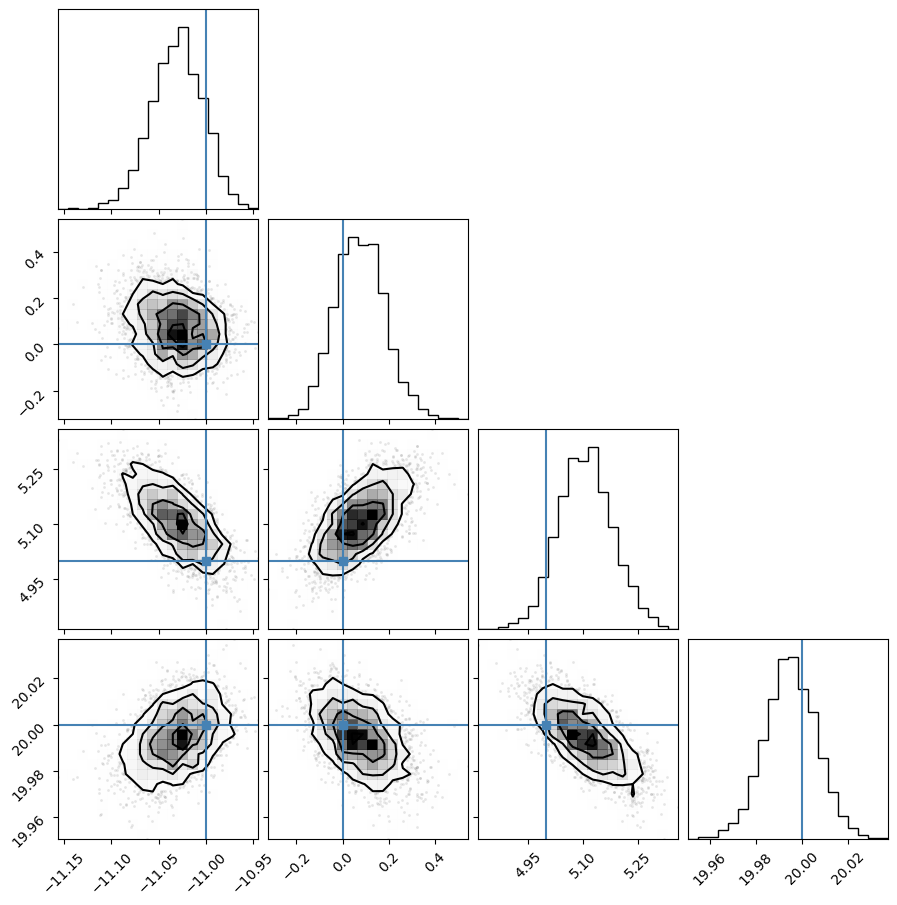

In [15]:
import corner

fig = corner.corner(
    sampler.get_chain(discard=200, thin=10, flat=True), truths=data_sample['z']
)

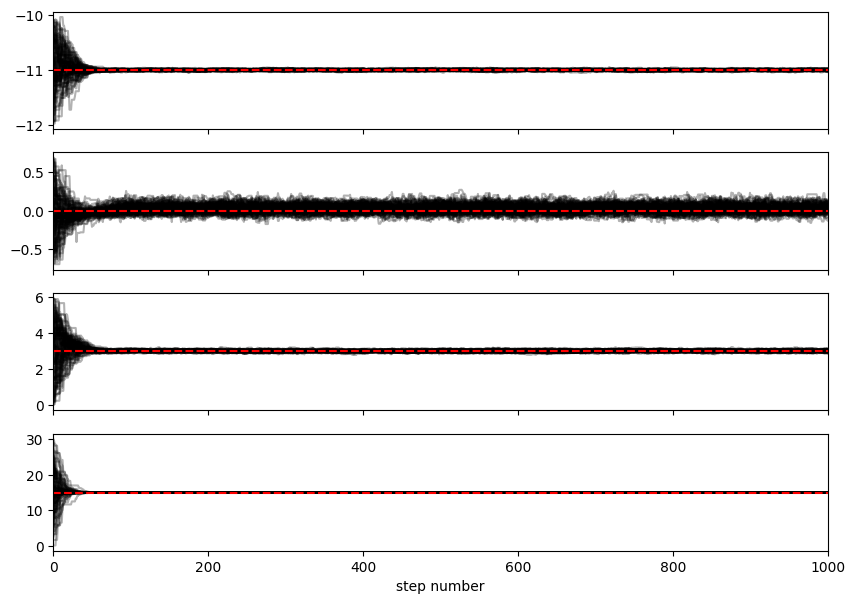

In [339]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

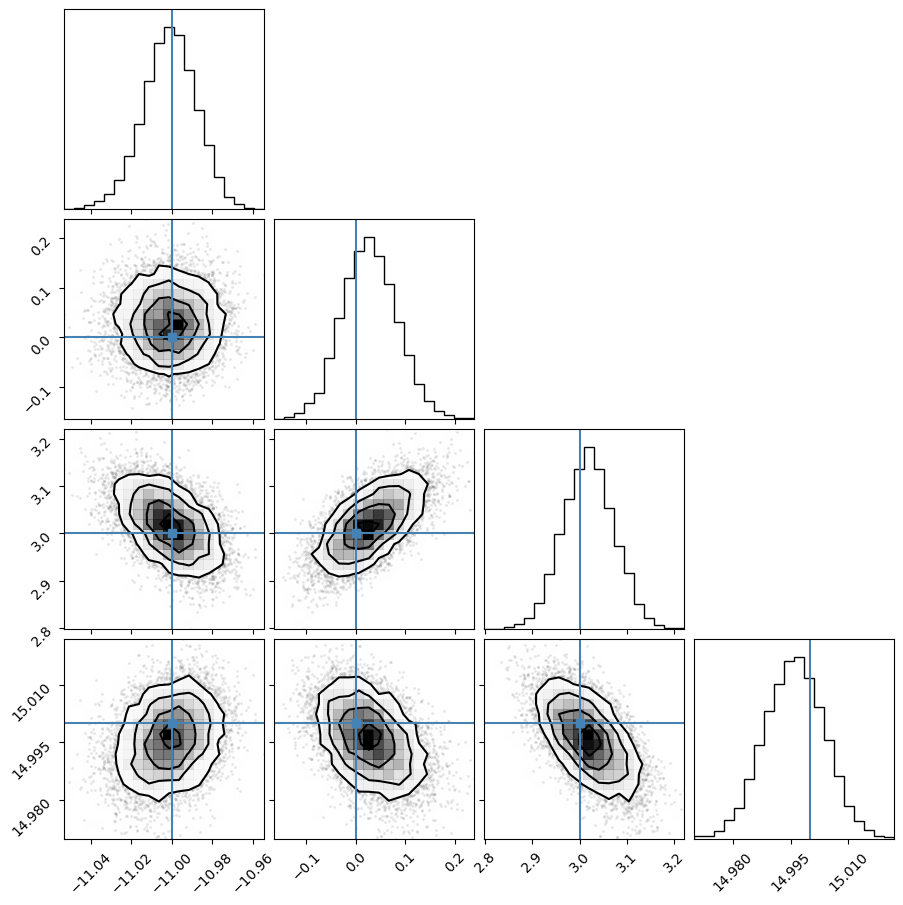

In [340]:
import corner

fig = corner.corner(
    sampler.get_chain(discard=200, thin=10, flat=True), truths=target_z
)

In [298]:
np.std(sampler.get_chain(discard=200, thin=5, flat=True), axis=0)

array([0.01286271, 0.05451975, 0.0559342 , 0.00790509])

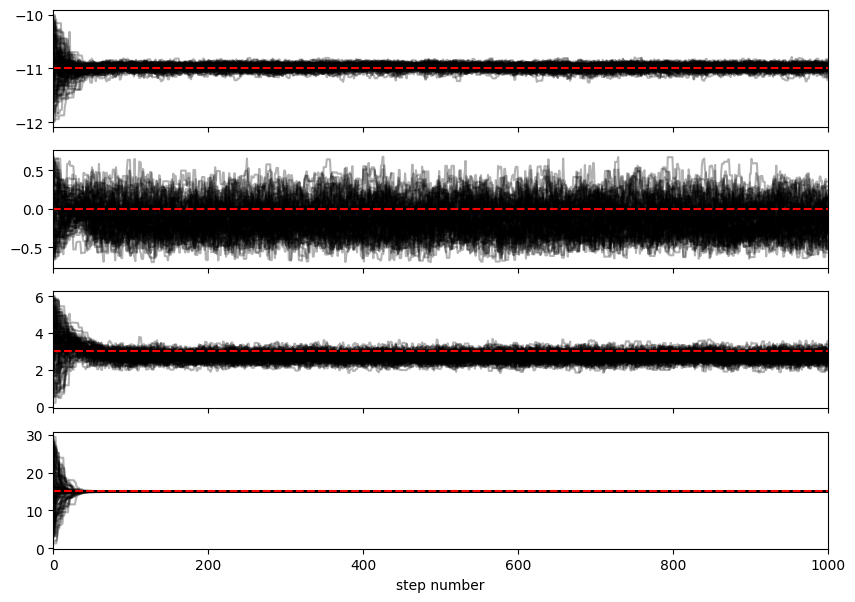

In [253]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

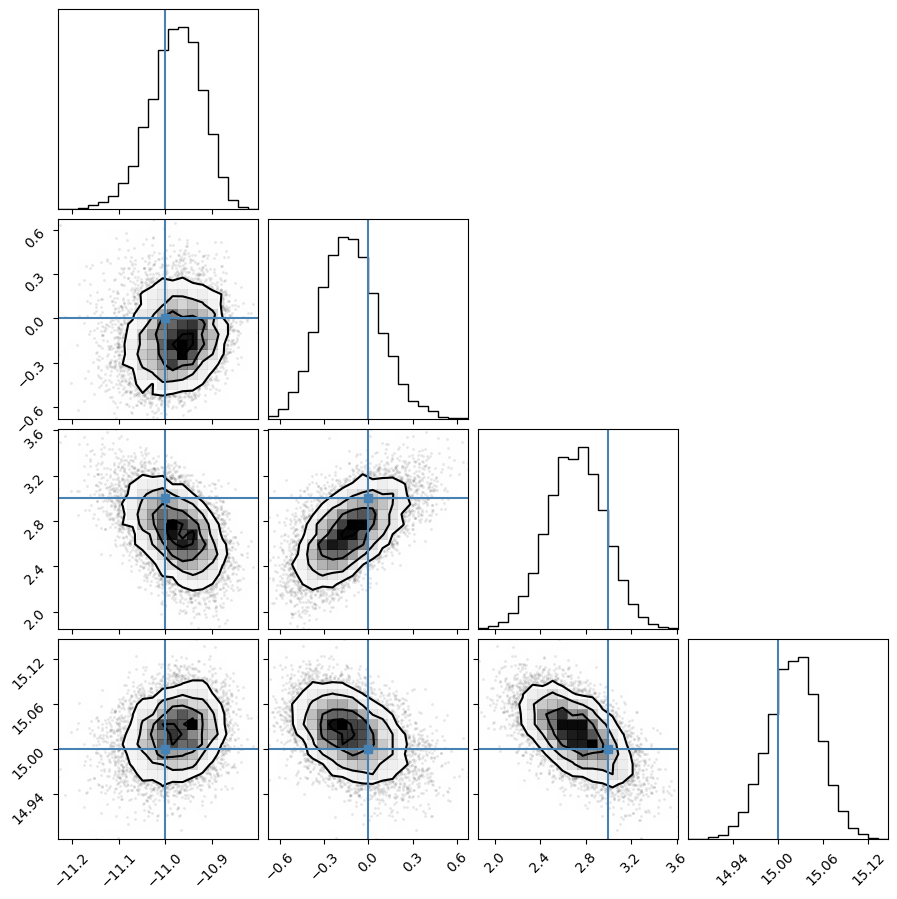

In [254]:
import corner

fig = corner.corner(
    sampler.get_chain(discard=200, thin=10, flat=True), truths=target_z
)

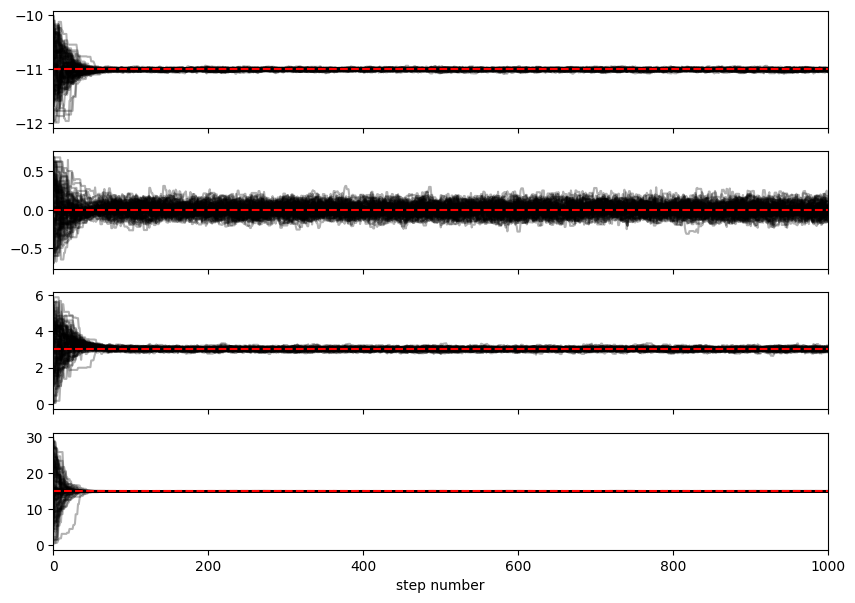

In [269]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

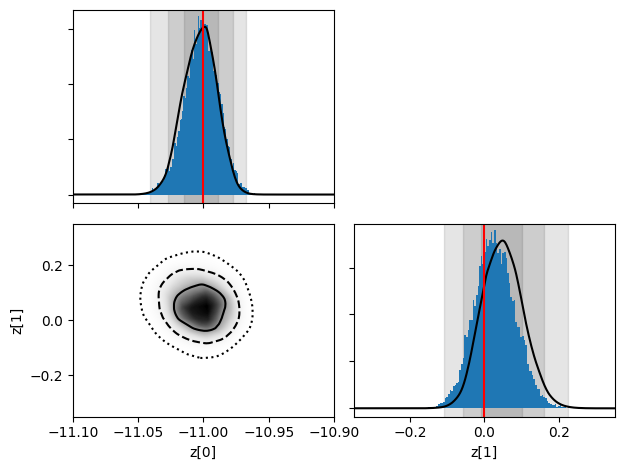

In [343]:
import corner

# fig = corner.corner(
#     sampler.get_chain(discard=200, thin=10, flat=True)[:, :2], density=True, truths=target_z[:2]
# )
swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000)
lims = [[-11.1, -10.9], [-0.35, 0.35]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.hist(sampler.get_chain(discard=200, thin=5, flat=True)[:, j], bins=100, density=True)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

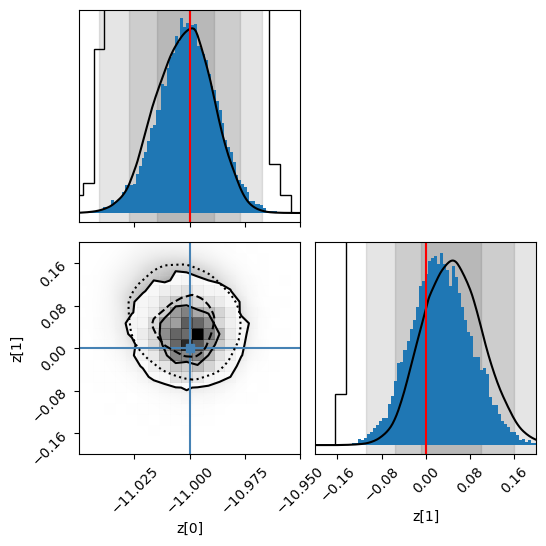

In [379]:
post_samples = sampler.get_chain(discard=200, thin=10, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.05, -10.95], [-0.2, 0.2]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
    plt.hist(sampler.get_chain(discard=200, thin=5, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

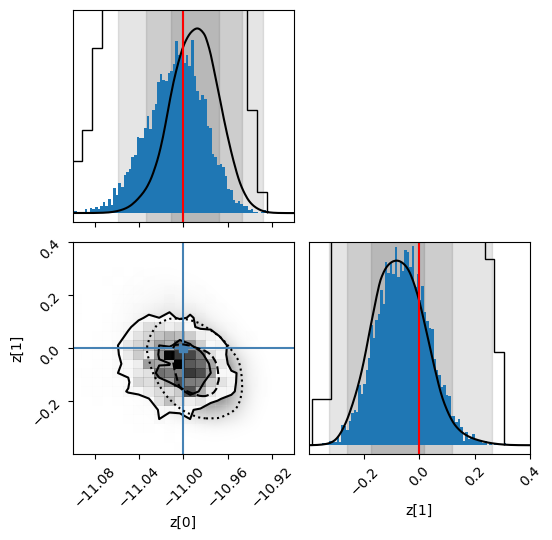

In [19]:
import corner
target_z = [-11., 0., 5., 20.]
post_samples = sampler.get_chain(discard=200, thin=10, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.1, -10.9], [-0.4, 0.4]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
    plt.hist(sampler.get_chain(discard=200, thin=5, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

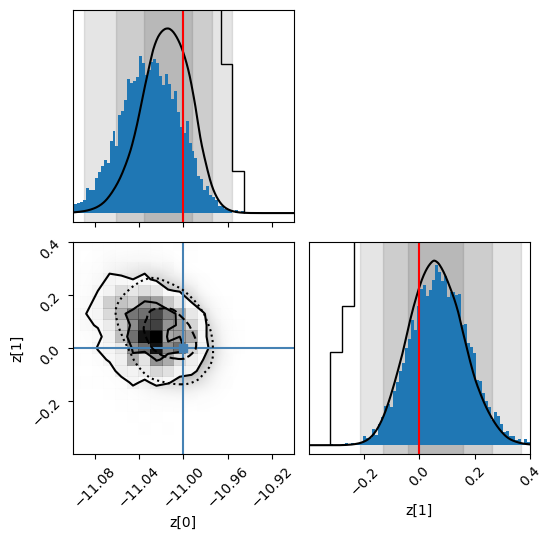

In [19]:
import corner
target_z = data_sample['z']
post_samples = sampler.get_chain(discard=200, thin=10, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.1, -10.9], [-0.4, 0.4]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(sampler.get_chain(discard=200, thin=5, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

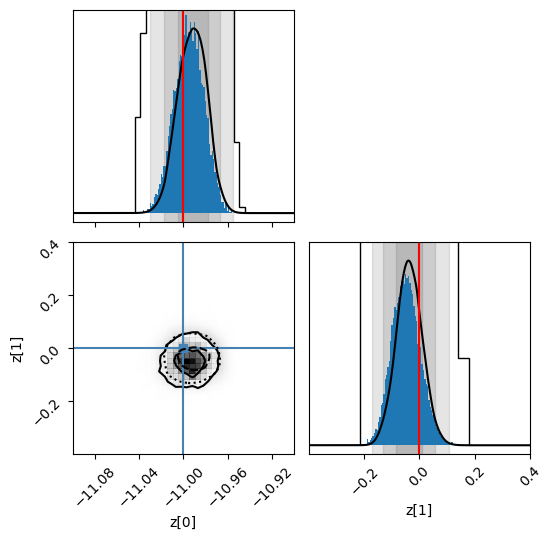

In [28]:
import corner
target_z = data_sample['z']
post_samples = sampler.get_chain(discard=200, thin=1, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.1, -10.9], [-0.4, 0.4]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(sampler.get_chain(discard=200, thin=1, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

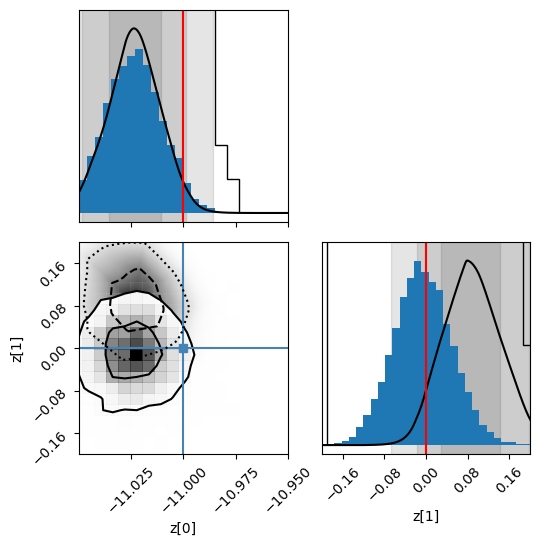

In [153]:
import corner
target_z = data_sample['z']
post_samples = one_sampler.get_chain(discard=200, thin=10, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=old_logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.05, -10.95], [-0.2, 0.2]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(one_sampler.get_chain(discard=200, thin=10, flat=True)[:, j], bins=30, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

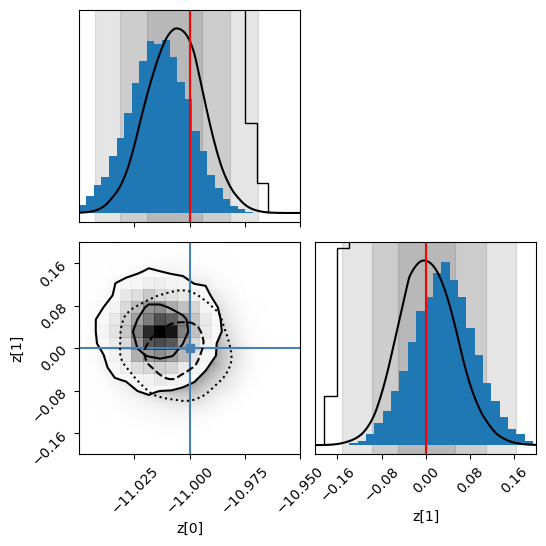

In [47]:
import corner
target_z = [-11.0, 0.0, 3.0, 15.0]
post_samples = complete_sampler.get_chain(discard=200, thin=5, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.05, -10.95], [-0.2, 0.2]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
    plt.hist(complete_sampler.get_chain(discard=200, thin=5, flat=True)[:, j], bins=30, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

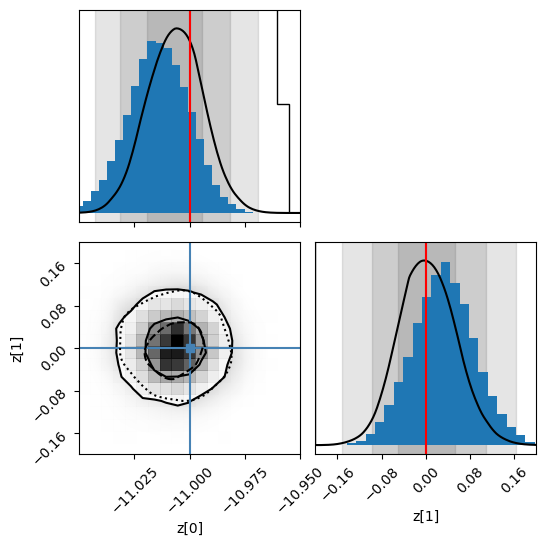

In [48]:
import corner
target_z = [-11.0, 0.0, 3.0, 15.0]
post_samples = restricted_sampler.get_chain(discard=100, thin=1, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.05, -10.95], [-0.2, 0.2]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
    plt.hist(complete_sampler.get_chain(discard=100, thin=1, flat=True)[:, j], bins=30, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [281]:
np.std(sampler.get_chain(discard=200, thin=15, flat=True), axis=0)

array([0.0133669 , 0.05149731, 0.05340847, 0.0076301 ])

In [300]:
cg_data = mcmc_sim.generate_coarse_grained_data(np.abs(data))

/home/alveyjbg/Code/public_releases/saqqara/examples/vary_noise/explore/../simulator/simulator.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  out[counter, j] = np.mean(
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/swyft/lightning/utils.py:398: RuntimeWarning: overflow encountered in cast
  x = np.float32(x)


In [302]:
cg_data_sim = sim.generate_coarse_grained_data(np.abs(data))

/home/alveyjbg/Code/public_releases/saqqara/examples/vary_noise/explore/../simulator/simulator.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  out[counter, j] = np.mean(
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/swyft/lightning/utils.py:398: RuntimeWarning: overflow encountered in cast
  x = np.float32(x)


In [30]:
id = "6ER5" # "OO2F" # "UD3J" # "NIEV" # "I4PW"
config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
settings = saqqara.load_settings(config_path=config)
sim = LISA_AET(settings)
network = SignalAET(settings=settings, sim=sim)
network = saqqara.load_state(network=network, ckpt=ckpt)
trainer = saqqara.setup_trainer(settings, logger=None)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


In [5]:
def get_grid(N=1000, a_low=-11.42961597442627, a_high=-10.696080207824707, g_low=-0.7066106200218201, g_high=1.0477334260940552):
    a_samples = np.linspace(a_low, a_high, N)
    g_samples = np.linspace(g_low, g_high, N)
    ag_samples = np.array(np.meshgrid(a_samples, g_samples)).T.reshape(-1, 2)
    A_samples = np.ones(N)
    P_samples = np.ones(N)
    AP_samples = np.array(np.meshgrid(A_samples, P_samples)).T.reshape(-1, 2)
    return swyft.Samples(z=np.float32(np.concatenate((ag_samples, AP_samples), axis=1)))
prior_samples = get_grid(N=2000)

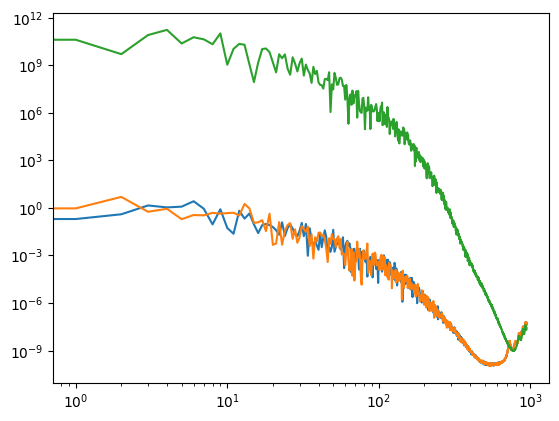

In [35]:
plt.loglog(torch.tensor(sim.generate_coarse_grained_data_from_sum(np.array(restricted_data * sim.response_AET))))

In [13]:
#observation = swyft.Sample(data=sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})['full_coarse_grained_data'])
id = "G7RG" # "G7RG" # "F46J" # "5TWY" # "OO2F" # "6ER5"
ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
settings = saqqara.load_settings(config_path=config)
network = SignalAET(settings=settings, sim=sim)
network = saqqara.load_state(network=network, ckpt=ckpt)
logratios = trainer.infer(network, observation, prior_samples, batch_size=100000)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0:  12%|█▎        | 5/40 [00:01<00:10,  3.27it/s] 

Predicting DataLoader 0: 100%|██████████| 40/40 [00:15<00:00,  2.65it/s]


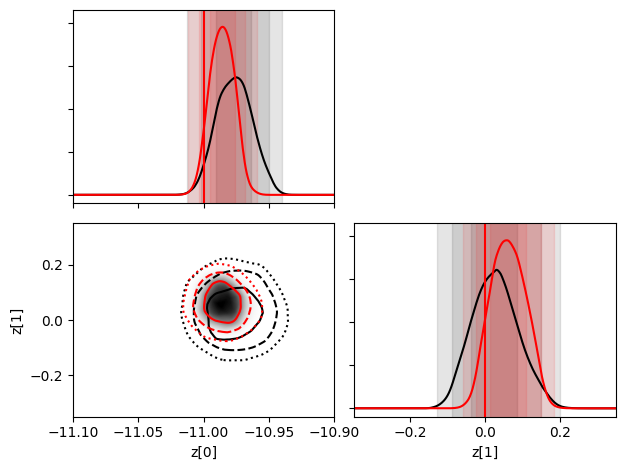

In [14]:
swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0)
target_z = [-11.0, 0.0, 3.0, 15.0]
swyft.plot_corner(old_logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0, color='r', fig=plt.gcf())
lims = [[-11.1, -10.9], [-0.35, 0.35]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [21]:
observation = swyft.Sample(data=data_sample['full_coarse_grained_data'])
id = "DZ66" # "G7RG" # "F46J" # "5TWY" # "OO2F" # "6ER5"
ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
settings = saqqara.load_settings(config_path=config)
network = SignalAET(settings=settings, sim=sim)
network = saqqara.load_state(network=network, ckpt=ckpt)
logratios = trainer.infer(network, observation, prior_samples, batch_size=100000)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0:  70%|███████   | 28/40 [00:14<00:06,  1.98it/s]

Predicting DataLoader 0: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


In [13]:
from scipy.integrate import simps
from scipy.interpolate import interp1d
def get_sigmas(logratios):
    lrs = np.array(logratios.logratios[:, 0].reshape(int(np.sqrt(logratios.logratios.shape[0])), int(np.sqrt(logratios.logratios.shape[0]))))
    params_alpha = np.array(logratios.params[:, 0, 0].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    params_gamma = np.array(logratios.params[:, 0, 1].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    posterior = np.exp(lrs - np.max(lrs)) / np.sum(np.exp(lrs - np.max(lrs))) / (params_alpha[1, 0] - params_alpha[0, 0]) * (params_gamma[0, 1] - params_gamma[0, 0])
    alpha_marginal = simps(posterior, params_gamma, axis=1)
    gamma_marginal = simps(posterior, params_alpha, axis=0)
    alpha_ps = params_alpha[:, 0]
    gamma_ps = params_gamma[0, :]
    norm_alpha_marginal = alpha_marginal / simps(alpha_marginal, alpha_ps) 
    norm_gamma_marginal = gamma_marginal / simps(gamma_marginal, gamma_ps)
    alpha_cumulant =  np.cumsum(norm_alpha_marginal * (alpha_ps[1] - alpha_ps[0]))
    gamma_cumulant =  np.cumsum(norm_gamma_marginal * (gamma_ps[1] - gamma_ps[0]))
    alpha_interp = interp1d(alpha_cumulant, alpha_ps)
    gamma_interp = interp1d(gamma_cumulant, gamma_ps)
    alpha_sigma = 0.5 * (alpha_interp(0.5 + 0.34) - alpha_interp(0.5 - 0.34))
    gamma_sigma = 0.5 * (gamma_interp(0.5 + 0.34) - gamma_interp(0.5 - 0.34))
    return alpha_sigma, gamma_sigma

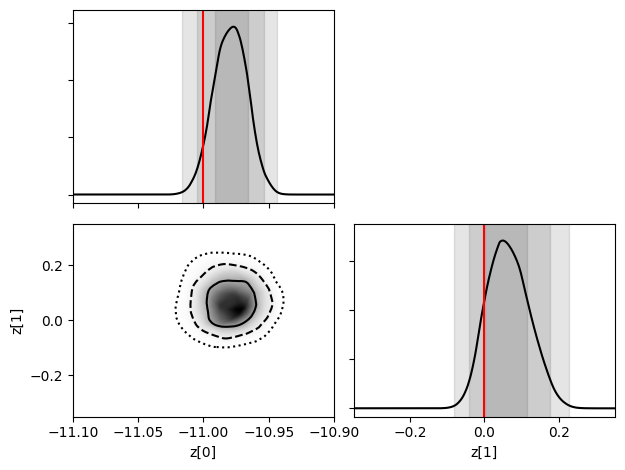

In [22]:
swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0)
target_z = [-11.0, 0.0, 3.0, 15.0]
#swyft.plot_corner(old_logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0, color='r', fig=plt.gcf())
lims = [[-11.1, -10.9], [-0.35, 0.35]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [15]:
get_sigmas(logratios)

/tmp/ipykernel_1320251/2702610411.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  alpha_marginal = simps(posterior, params_gamma, axis=1)
/tmp/ipykernel_1320251/2702610411.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  gamma_marginal = simps(posterior, params_alpha, axis=0)
/tmp/ipykernel_1320251/2702610411.py:12: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm_alpha_marginal = alpha_marginal / simps(alpha_marginal, alpha_ps)
/tmp/ipykernel_1320251/2702610411.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm_gamma_marginal = gamma_marginal / simps(gamma_marginal, gamma_ps)


(0.013328155660092378, 0.05488023701498943)

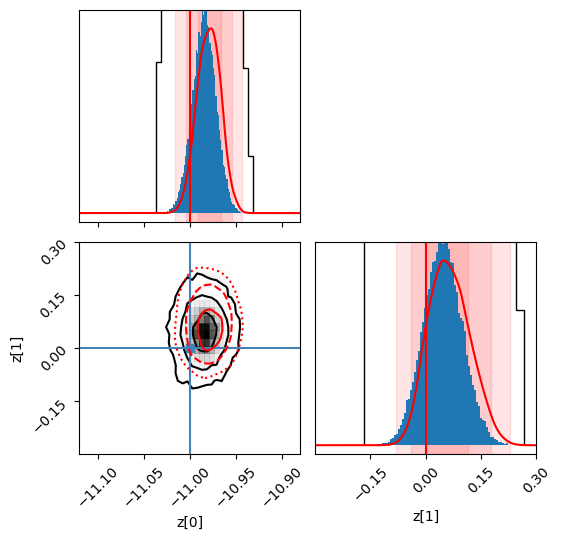

In [23]:
import corner
target_z = data_sample['z']
post_samples = stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, :2]
fig = corner.corner(
    post_samples,
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)]
)
colors = ["black", "red", "green"]
lims = [[-11.12, -10.88], [-0.3, 0.3]]
swyft.plot_corner(logratios, color='red', parnames=logratios.parnames[0], bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)], fig=plt.gcf())
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

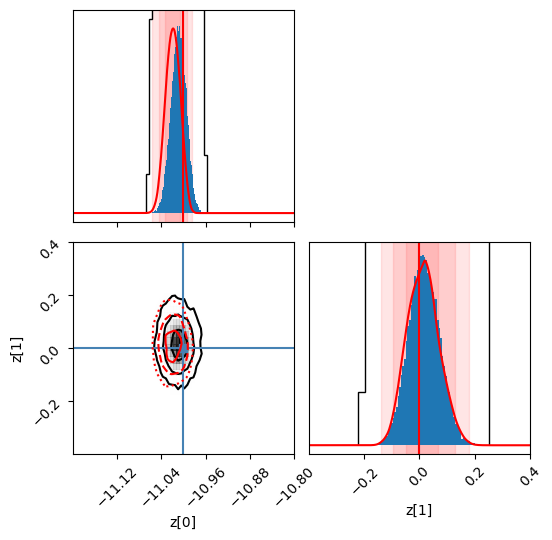

In [43]:
import corner
target_z = data_sample['z']
post_samples = stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, :2]
fig = corner.corner(
    post_samples,
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)]
)
colors = ["black", "red", "green"]
lims = [[-11.2, -10.8], [-0.4, 0.4]]
swyft.plot_corner(logratios, color='red', parnames=logratios.parnames[0], bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)], fig=plt.gcf())
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 40/40 [00:26<00:00,  1.53it/s]


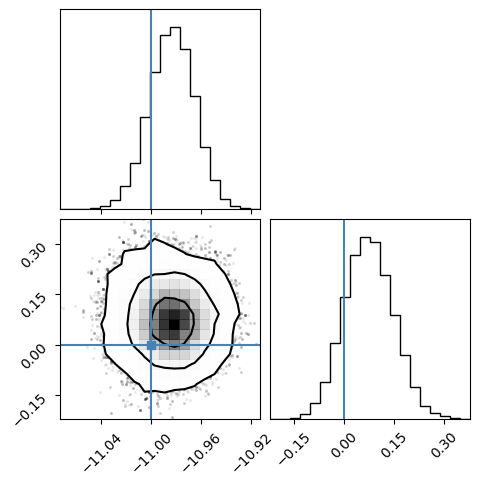

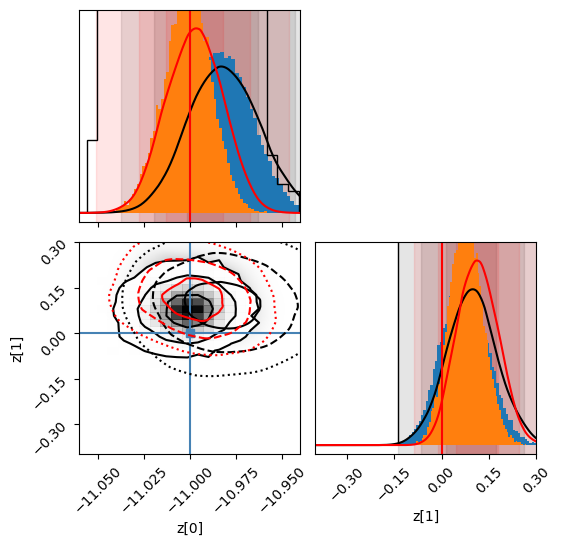

In [136]:
import corner
target_z = data_sample['z']
post_samples = A_stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)]
)
post_samples = AA_stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)]
)
colors = ["black", "red", "green"]
for idx, id in enumerate(["F46J", "OO2F"]): #"5TWY", "OO2F", "6ER5"]):
    # id = "5TWY" # "OO2F" # "6ER5"
    ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
    config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
    settings = saqqara.load_settings(config_path=config)
    network = SignalAET(settings=settings, sim=sim)
    network = saqqara.load_state(network=network, ckpt=ckpt)
    logratios = trainer.infer(network, observation, prior_samples, batch_size=100000)
    swyft.plot_corner(logratios, color=colors[idx], parnames=logratios.parnames[0], bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)], fig=plt.gcf())
#lims = [[-11.06, -10.94], [-0.4, 0.3]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(A_stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, j], bins=80, density=True)
    plt.hist(AA_stats_sampler.get_chain(discard=100, thin=1, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

(array([1.6000e+01, 3.4300e+02, 2.8380e+03, 1.2246e+04, 2.7471e+04,
        3.1395e+04, 1.8932e+04, 5.8260e+03, 8.5100e+02, 8.2000e+01]),
 array([-6.16238029, -4.98047106, -3.79856184, -2.61665262, -1.43474339,
        -0.25283417,  0.92907506,  2.11098428,  3.2928935 ,  4.47480273,
         5.65671195]),
 <BarContainer object of 10 artists>)

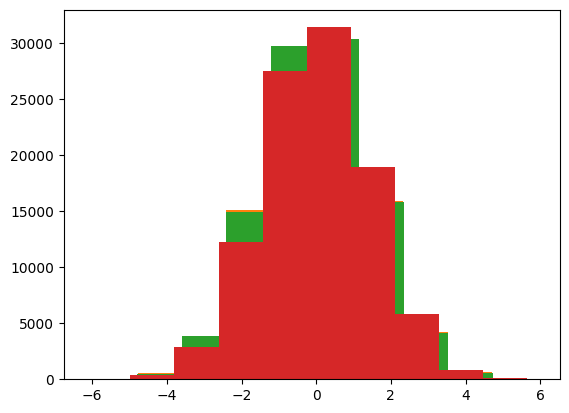

In [140]:
x_s_samples = []
y_s_samples = []
x_ss_samples = []
y_ss_samples = []
sigma_s, sigma_n = 1., 1.
for _ in range(100000):
    n1 = np.random.normal(0., sigma_n)
    n2 = np.random.normal(0., sigma_n)
    s1 = np.random.normal(0., sigma_s)
    s2 = np.random.normal(0., sigma_s)
    x_s_samples.append(n1 + s1)
    y_s_samples.append(n2 + s1)
    x_ss_samples.append(n1 + s1)
    y_ss_samples.append(n2 + s2)
plt.hist(x_s_samples)
plt.hist(y_s_samples)
plt.hist(x_ss_samples)
plt.hist(y_ss_samples)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-5.97683227, -5.85790701, -5.73898176, -5.62005651, -5.50113126,
        -5.382206  , -5.26328075, -5.1443555 , -5.02543024, -4.90650499,
        -4.78757974, -4.66865449, -4.54972923, -4.43080398, -4.31187873,
        -4.19295347, -4.07402822, -3.95510297, -3.83617771, -3.71725246,
        -3.59832721, -3.47940196, -3.3604767 , -3.24155145, -3.1226262 ,
        -3.00370094, -2.88477569, -2.76585044, -2.64692518, -2.52799993,
        -2.40907468, -2.29014943, -2.17122417, -2.05229892, -1.93337367,
        -1.81444841, -1.69552316, -1.57659791, -1.45767266, -1.3387474 ,
        -1.21982215, -1.1008969 , -0.98197164, -0.86304639, -0.74412114,
        -0.62519588, -0.50627063, -0.38734538, -0.26842013, -0.14949487,
        -0.03056962, 

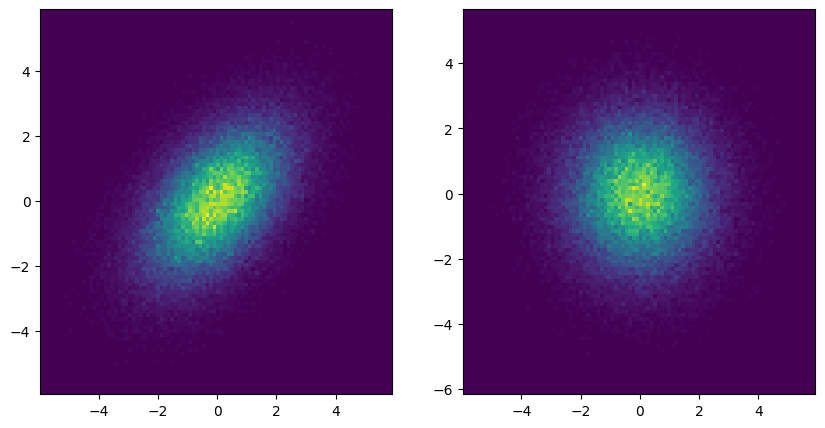

In [145]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plt.hist2d(x_s_samples, y_s_samples, bins=100)
ax = plt.subplot(1, 2, 2)
plt.hist2d(x_ss_samples, y_ss_samples, bins=100)

Detector setup complete
Noise matrices computed


Response computed


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Coarse graining setup complete
Predicting DataLoader 0: 100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


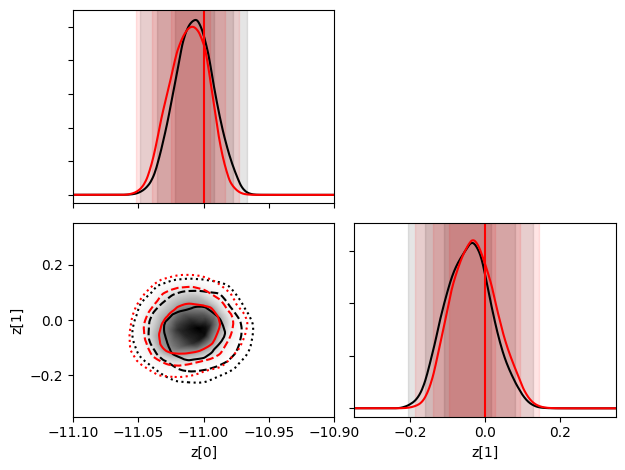

In [9]:
id = "DZ66"
config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
settings = saqqara.load_settings(config_path=config)
sim = LISA_AET(settings)
network = SignalAET(settings=settings, sim=sim)
network = saqqara.load_state(network=network, ckpt=ckpt)  
#old_observation = swyft.Sample(data=sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})["coarse_grained_data"])
old_logratios = trainer.infer(network, observation, prior_samples, batch_size=100000)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0)
swyft.plot_corner(old_logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0, color='r', fig=plt.gcf())
lims = [[-11.1, -10.9], [-0.35, 0.35]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [22]:
data_sample.keys()

dict_keys(['z', 'linear_signal_AET', 'quadratic_signal_AET', 'linear_TM_noise_AET', 'linear_OMS_noise_AET', 'quadratic_noise_AET', 'quadratic_data_AET', 'full_quadratic_data_AET', 'coarse_grained_data', 'full_coarse_grained_data'])

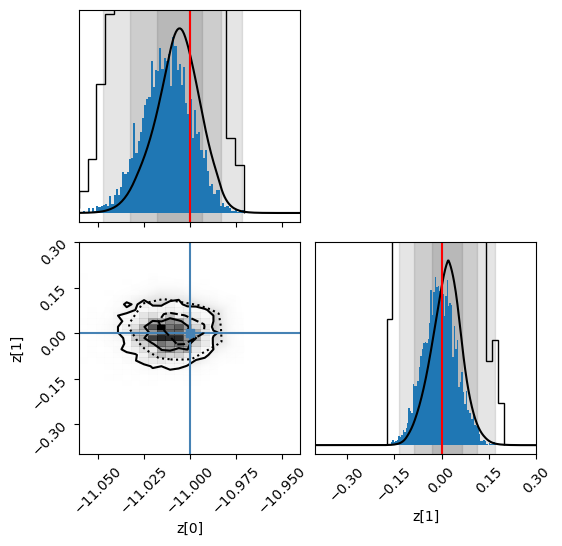

In [96]:
import corner
target_z = data_sample['z']
post_samples = sampler.get_chain(discard=100, thin=10, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.06, -10.94], [-0.4, 0.3]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
    plt.hist(sampler.get_chain(discard=100, thin=10, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [14]:
observation = swyft.Sample(z=np.array([-11.0, 0.0, 3.0, 15.0]), data=data_sample['coarse_grained_data'])
logratios = trainer.infer(network, observation, prior_samples, batch_size=100000)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


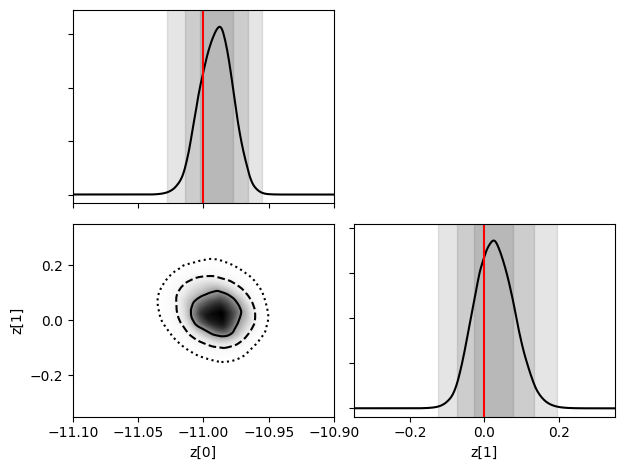

In [322]:
swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0)
lims = [[-11.1, -10.9], [-0.35, 0.35]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [382]:
jax.grad(stats.log_posterior)(np.array([-11.0, 0.0, 3.0, 15.0]), data)

Array([ -7.0890874 ,   8.94237603,  -5.04446518, -58.56317518], dtype=float64)

In [50]:
import operator as op
import jax
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_leaves, tree_reduce


def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None: treedef = jax.tree_util.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_util.tree_unflatten(treedef, keys)


def normal_like_tree(rng_key, target, mean=0, std=1):
    # https://github.com/google/jax/discussions/9508#discussioncomment-2144076
    keys_tree = random_split_like_tree(rng_key, target)
    return tree_map(lambda l, k: mean + std*jax.random.normal(k, l.shape, l.dtype), target, keys_tree)


def ifelse(cond, val_true, val_false):
    return jax.lax.cond(cond, lambda x: x[0], lambda x: x[1], (val_true, val_false))


def leapfrog(params, momentum, log_prob_fn, step_size, n_steps):
    """Approximates Hamiltonian dynamics using the leapfrog algorithm."""

    # define a single step
    def step(i, args):
        params, momentum = args

        # update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum = tree_map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)

        # update params
        params = tree_map(lambda p, m: p + m * step_size, params, momentum)

        # update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum = tree_map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)

        return params, momentum

    # do 'n_steps'
    new_params, new_momentum = jax.lax.fori_loop(0, n_steps, step, (params, momentum))

    return new_params, new_momentum


def hmc_sample(key, params_init, log_prob_fn, n_steps, n_leapfrog_steps, step_size):
    """
    Runs HMC and returns the full Markov chain as a Pytree.
    - params: array
    - log_prob_fn: function that takes params as the only argument and returns a scalar value
    """

    # define a single step
    def step_fn(carry, x):
        params, key = carry
        key, normal_key, uniform_key = jax.random.split(key, 3)

        # generate random momentum
        momentum = normal_like_tree(key, params)

        # leapfrog
        new_params, new_momentum = leapfrog(params, momentum, log_prob_fn, step_size, n_leapfrog_steps)

        # MH correction
        potentaial_energy_diff = log_prob_fn(new_params) - log_prob_fn(params)
        momentum_dot = tree_reduce(op.add, tree_map(lambda x: (x**2).sum(), tree_leaves(momentum)))
        new_momentum_dot = tree_reduce(op.add, tree_map(lambda x: (x**2).sum(), tree_leaves(new_momentum)))
        kinetic_energy_diff = 0.5*(momentum_dot - new_momentum_dot)
        log_accept_prob = potentaial_energy_diff + kinetic_energy_diff
        log_accept_prob = jnp.nan_to_num(log_accept_prob, nan=-jnp.inf)
        accept_prob = jnp.minimum(1, jnp.exp(log_accept_prob))
        accept = jax.random.uniform(uniform_key) < accept_prob
        params = ifelse(accept, new_params, params)

        return (params, key), (params, accept_prob)

    # do 'n_steps'
    _, (chain, accept_prob) = jax.lax.scan(step_fn, (params_init, key), xs=None, length=n_steps)
    
    print(f'accept={accept_prob.mean():.2%}')
    return chain

In [39]:
params_init

array([-10.454525  ,  -0.59005547,   3.1602752 ,   4.682291  ],
      dtype=float32)

In [40]:
z = jnp.array([-11., 0., 3., 15.])

In [41]:
stats.sim.prior.bounds[:, 0] - z

Array([ -1. ,  -0.7,  -3. , -15. ], dtype=float64)

In [42]:
jnp.prod(jnp.heaviside(z - stats.sim.prior.bounds[:, 0], 0) * jnp.heaviside(stats.sim.prior.bounds[:, 1] - z, 0))

Array(1., dtype=float64)

In [43]:
log_posterior(z)

Array(3.7252903e-09, dtype=float64)

In [73]:
params_init = stats.sim.prior.sample()
key = jax.random.PRNGKey(0)

def log_prior(z):
    condition = jnp.prod(jnp.heaviside(z - stats.sim.prior.bounds[:, 0], 0) * jnp.heaviside(stats.sim.prior.bounds[:, 1] - z, 0))
    return -1000000. * (1 - condition)

def log_posterior(z):
    return stats.logL(z, data) + log_prior(z)

chain = hmc_sample(key, params_init, log_posterior, n_steps=1000, n_leapfrog_steps=10, step_size=0.001)

accept=99.30%


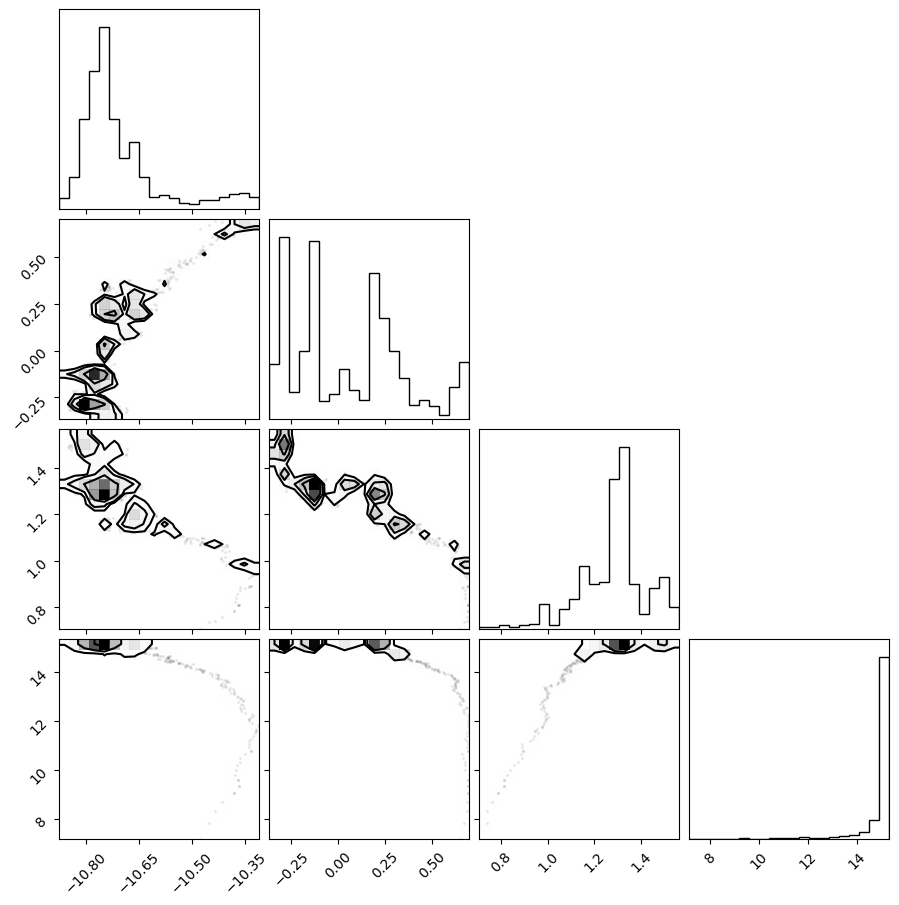

In [74]:
import corner
corner.corner(np.array(chain));

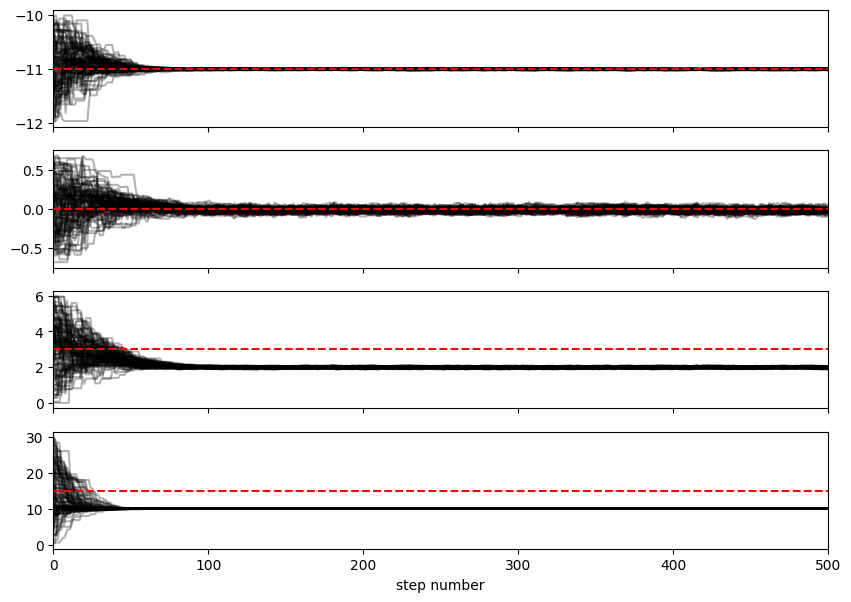

In [86]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
target_z = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(target_z[i], color='r', linestyle='--')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

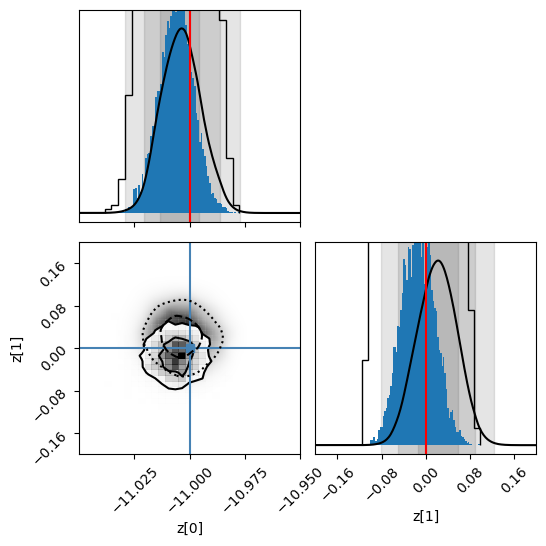

In [90]:
post_samples = sampler.get_chain(discard=100, thin=5, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(logratios, parnames=logratios.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)])
lims = [[-11.05, -10.95], [-0.2, 0.2]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
    plt.hist(sampler.get_chain(discard=100, thin=5, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [101]:
def long_mcmc(stats, data, nsegs=100, nwalkers=100, nsteps=1000):
    ndim = 4
    p0 = stats.sim.prior.sample(nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, stats.log_posterior, args=[data, nsegs])
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler

In [97]:
cg_data_samples = []
new_data_sample = stats.sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})
full_data = stats.get_quad_data(new_data_sample)
cg_data_samples.append(new_data_sample['coarse_grained_data'])
for idx in tqdm(range(99)):
    new_data_sample = stats.sim.sample(conditions={'z': np.array([-11.0, 0.0, 3.0, 15.0])})
    new_data = stats.get_quad_data(new_data_sample)
    full_data += new_data
    cg_data_samples.append(new_data_sample['coarse_grained_data'])

100%|██████████| 99/99 [03:49<00:00,  2.32s/it]


In [98]:
quad_data_to_sample = full_data / 100

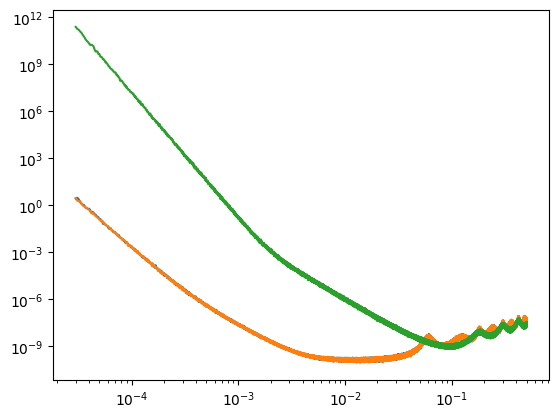

In [99]:
plt.loglog(stats.sim.f_vec, quad_data_to_sample)

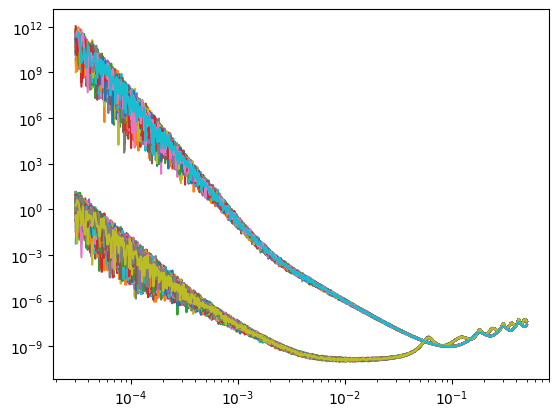

In [100]:
for idx in range(100):
    plt.loglog(stats.sim.coarse_grained_f, cg_data_samples[idx])

In [102]:
sampler = long_mcmc(stats, quad_data_to_sample, nsegs=100, nwalkers=100, nsteps=500)

100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


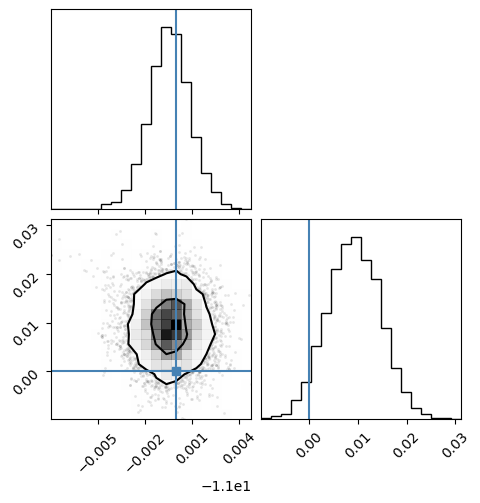

In [103]:
import corner
target_z = [-11., 0., 3., 15.]
post_samples = sampler.get_chain(discard=100, thin=5, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)

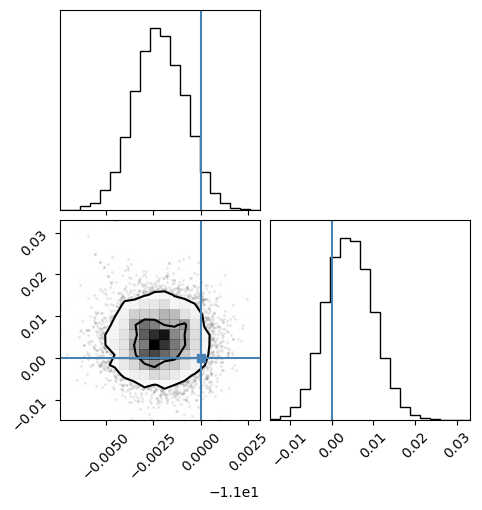

In [18]:
import corner
target_z = [-11., 0., 3., 15.]
post_samples = sampler.get_chain(discard=100, thin=5, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)

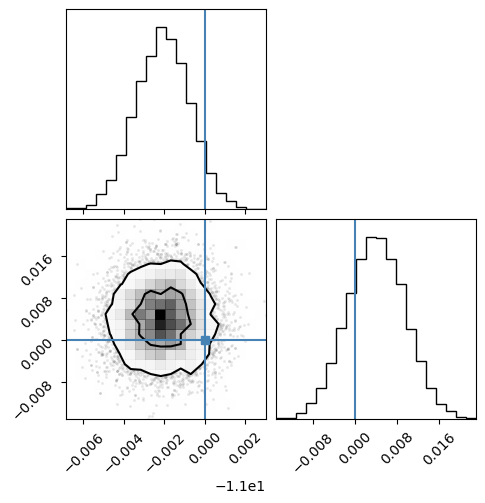

In [59]:
import corner
target_z = [-11., 0., 3., 15.]
post_samples = sampler.get_chain(discard=100, thin=5, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)

In [35]:
def get_grid(N=1000, a_low=-11.42961597442627, a_high=-10.696080207824707, g_low=-0.7066106200218201, g_high=1.0477334260940552):
    a_samples = np.linspace(a_low, a_high, N)
    g_samples = np.linspace(g_low, g_high, N)
    ag_samples = np.array(np.meshgrid(a_samples, g_samples)).T.reshape(-1, 2)
    A_samples = np.ones(N)
    P_samples = np.ones(N)
    AP_samples = np.array(np.meshgrid(A_samples, P_samples)).T.reshape(-1, 2)
    return swyft.Samples(z=np.float32(np.concatenate((ag_samples, AP_samples), axis=1)))

def get_network(id, sim):
    config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
    ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
    settings = saqqara.load_settings(config_path=config)
    network = SignalAET(settings=settings, sim=sim)
    network = saqqara.load_state(network=network, ckpt=ckpt)
    return network

In [45]:
net = get_network("5RU6", sim)
logratios = trainer.infer(net, observation, prior_samples, batch_size=100000)
print(logratios.parnames)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s] 
[['z[0]']
 ['z[1]']]


In [104]:
N = 1000
lrs_total = swyft.LogRatioSamples(
    logratios=torch.zeros((N * N, 1)),
    params=torch.zeros((N * N, 1, 2)),
    parnames=[
        ["z[0]", "z[1]"],
    ],
)
#net = get_network("SIMF", sim)
prior_samples = get_grid(N=N, a_low=-11.12569522857666, a_high=-10.895430564880371, g_low=-0.434512734413147, g_high=0.6660090684890747)
for i in tqdm(range(100)):
    batch = cg_data_samples[i]
    observation = swyft.Sample(data=batch)
    logratios = trainer.infer(network, observation, prior_samples, batch_size=100000)
    lrs_total.logratios += logratios.logratios
    lrs_total.params = logratios.params

  0%|          | 0/100 [00:00<?, ?it/s]/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0:  20%|██        | 2/10 [00:00<00:01,  7.55it/s] 

Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

  1%|          | 1/100 [00:04<06:54,  4.19s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

  2%|▏         | 2/100 [00:07<06:26,  3.95s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

  3%|▎         | 3/100 [00:12<06:30,  4.02s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

  4%|▍         | 4/100 [00:16<06:30,  4.06s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

  5%|▌         | 5/100 [00:20<06:26,  4.07s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

  6%|▌         | 6/100 [00:24<06:23,  4.08s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

  7%|▋         | 7/100 [00:28<06:20,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

  8%|▊         | 8/100 [00:32<06:17,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

  9%|▉         | 9/100 [00:36<06:13,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 10%|█         | 10/100 [00:40<06:09,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 11%|█         | 11/100 [00:44<06:04,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 12%|█▏        | 12/100 [00:49<06:00,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 13%|█▎        | 13/100 [00:53<05:56,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 14%|█▍        | 14/100 [00:57<05:51,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 15%|█▌        | 15/100 [01:01<05:47,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 16%|█▌        | 16/100 [01:05<05:44,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

 17%|█▋        | 17/100 [01:09<05:39,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 18%|█▊        | 18/100 [01:13<05:35,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 19%|█▉        | 19/100 [01:17<05:32,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 20%|██        | 20/100 [01:21<05:28,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

 21%|██        | 21/100 [01:26<05:26,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 22%|██▏       | 22/100 [01:30<05:21,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 23%|██▎       | 23/100 [01:34<05:17,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 24%|██▍       | 24/100 [01:38<05:12,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

 25%|██▌       | 25/100 [01:42<05:07,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 26%|██▌       | 26/100 [01:46<05:03,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

 27%|██▋       | 27/100 [01:50<05:00,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 28%|██▊       | 28/100 [01:54<04:56,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 29%|██▉       | 29/100 [01:58<04:51,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

 30%|███       | 30/100 [02:02<04:46,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 31%|███       | 31/100 [02:06<04:42,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 32%|███▏      | 32/100 [02:11<04:38,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

 33%|███▎      | 33/100 [02:15<04:35,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 34%|███▍      | 34/100 [02:19<04:31,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 35%|███▌      | 35/100 [02:23<04:26,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 36%|███▌      | 36/100 [02:27<04:22,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 37%|███▋      | 37/100 [02:31<04:18,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 38%|███▊      | 38/100 [02:35<04:14,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 39%|███▉      | 39/100 [02:39<04:10,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 40%|████      | 40/100 [02:43<04:06,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 41%|████      | 41/100 [02:48<04:02,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 42%|████▏     | 42/100 [02:52<03:58,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 43%|████▎     | 43/100 [02:56<03:54,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 44%|████▍     | 44/100 [03:00<03:50,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

 45%|████▌     | 45/100 [03:04<03:46,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 46%|████▌     | 46/100 [03:08<03:42,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

 47%|████▋     | 47/100 [03:12<03:38,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 48%|████▊     | 48/100 [03:16<03:34,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 49%|████▉     | 49/100 [03:21<03:30,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 50%|█████     | 50/100 [03:25<03:25,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

 51%|█████     | 51/100 [03:29<03:23,  4.15s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 52%|█████▏    | 52/100 [03:33<03:19,  4.15s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

 53%|█████▎    | 53/100 [03:37<03:16,  4.17s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 54%|█████▍    | 54/100 [03:41<03:11,  4.16s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

 55%|█████▌    | 55/100 [03:46<03:07,  4.17s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 56%|█████▌    | 56/100 [03:50<03:02,  4.15s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 57%|█████▋    | 57/100 [03:54<02:58,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 58%|█████▊    | 58/100 [03:58<02:53,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

 59%|█████▉    | 59/100 [04:02<02:50,  4.15s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

 60%|██████    | 60/100 [04:06<02:46,  4.15s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 61%|██████    | 61/100 [04:10<02:42,  4.15s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 62%|██████▏   | 62/100 [04:15<02:37,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

 63%|██████▎   | 63/100 [04:19<02:33,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 64%|██████▍   | 64/100 [04:23<02:28,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 65%|██████▌   | 65/100 [04:27<02:24,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 66%|██████▌   | 66/100 [04:31<02:20,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 67%|██████▋   | 67/100 [04:35<02:15,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 68%|██████▊   | 68/100 [04:39<02:11,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 69%|██████▉   | 69/100 [04:43<02:07,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 70%|███████   | 70/100 [04:47<02:02,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

 71%|███████   | 71/100 [04:52<01:59,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 72%|███████▏  | 72/100 [04:56<01:54,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 73%|███████▎  | 73/100 [05:00<01:50,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 74%|███████▍  | 74/100 [05:04<01:46,  4.09s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 75%|███████▌  | 75/100 [05:08<01:42,  4.08s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 76%|███████▌  | 76/100 [05:12<01:38,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 77%|███████▋  | 77/100 [05:16<01:34,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 78%|███████▊  | 78/100 [05:20<01:30,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 79%|███████▉  | 79/100 [05:24<01:26,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]

 80%|████████  | 80/100 [05:29<01:23,  4.15s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 81%|████████  | 81/100 [05:33<01:18,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

 82%|████████▏ | 82/100 [05:37<01:14,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 83%|████████▎ | 83/100 [05:41<01:10,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 84%|████████▍ | 84/100 [05:45<01:05,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 85%|████████▌ | 85/100 [05:49<01:01,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 86%|████████▌ | 86/100 [05:53<00:57,  4.12s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 87%|████████▋ | 87/100 [05:57<00:53,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

 88%|████████▊ | 88/100 [06:02<00:49,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

 89%|████████▉ | 89/100 [06:06<00:45,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

 90%|█████████ | 90/100 [06:10<00:41,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

 91%|█████████ | 91/100 [06:14<00:37,  4.14s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

 92%|█████████▏| 92/100 [06:18<00:33,  4.13s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 93%|█████████▎| 93/100 [06:22<00:28,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 94%|█████████▍| 94/100 [06:26<00:24,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

 95%|█████████▌| 95/100 [06:30<00:20,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 96%|█████████▌| 96/100 [06:34<00:16,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

 97%|█████████▋| 97/100 [06:39<00:12,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

 98%|█████████▊| 98/100 [06:43<00:08,  4.11s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

 99%|█████████▉| 99/100 [06:47<00:04,  4.10s/it]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

100%|██████████| 100/100 [06:51<00:00,  4.11s/it]

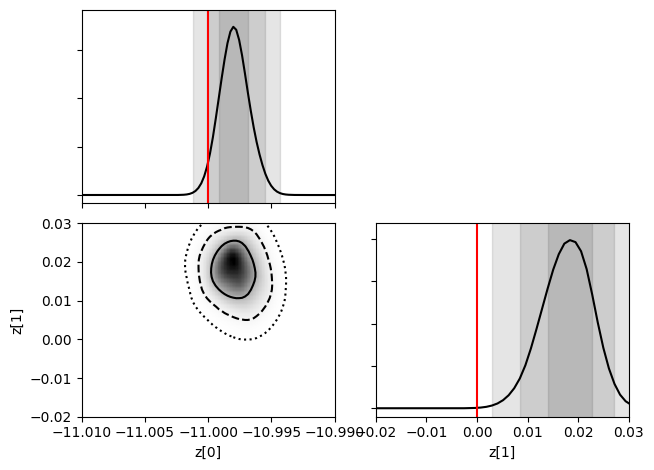

In [105]:
swyft.plot_corner(lrs_total, parnames=lrs_total.parnames[0], bins=1000, smooth=0.0)
lims = [[-11.01, -10.99], [-0.02, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

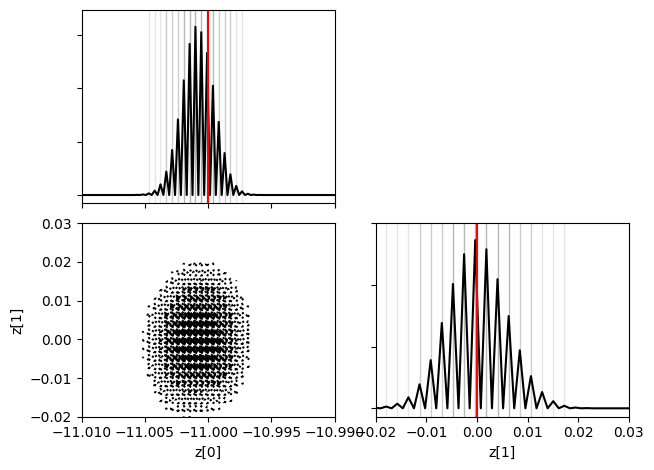

In [55]:
swyft.plot_corner(lrs_total, parnames=lrs_total.parnames[0], bins=1000, smooth=0.0)
lims = [[-11.01, -10.99], [-0.02, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

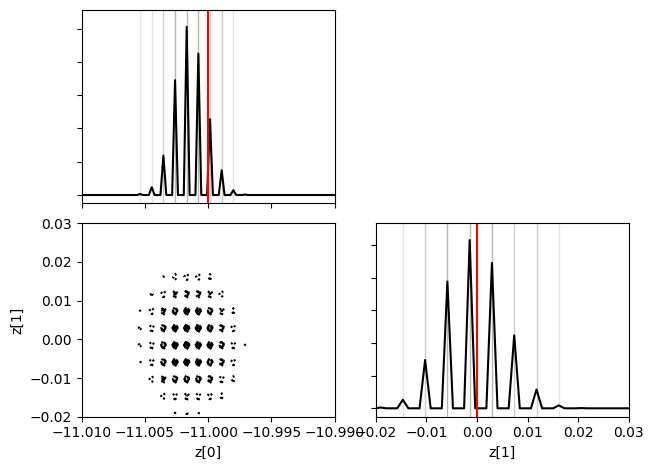

In [79]:
swyft.plot_corner(lrs_total, parnames=lrs_total.parnames[0], bins=1000, smooth=0.0)
lims = [[-11.01, -10.99], [-0.02, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

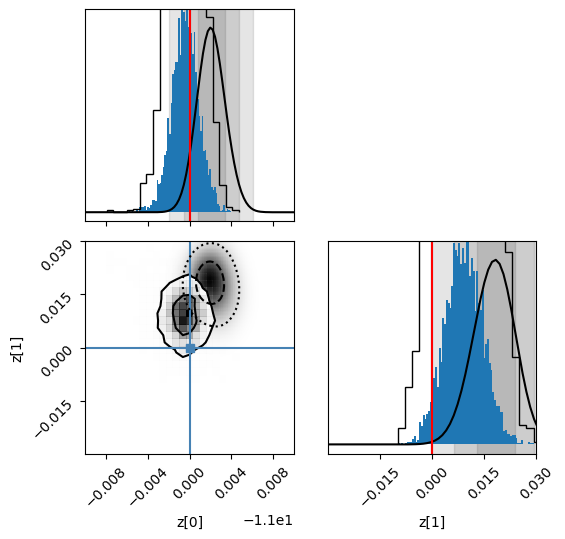

In [106]:
post_samples = sampler.get_chain(discard=100, thin=5, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(lrs_total, parnames=lrs_total.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)], smooth=3.0)
lims = [[-11.01, -10.99], [-0.03, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
    plt.hist(sampler.get_chain(discard=100, thin=10, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

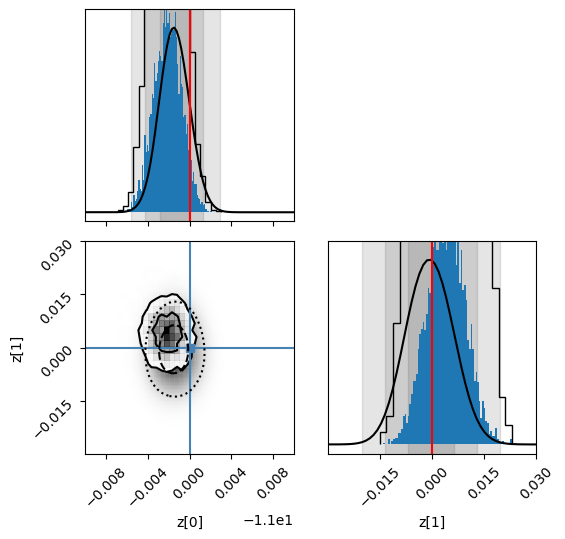

In [80]:
post_samples = sampler.get_chain(discard=100, thin=5, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(lrs_total, parnames=lrs_total.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)], smooth=3.0)
lims = [[-11.01, -10.99], [-0.03, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
    plt.hist(sampler.get_chain(discard=100, thin=10, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

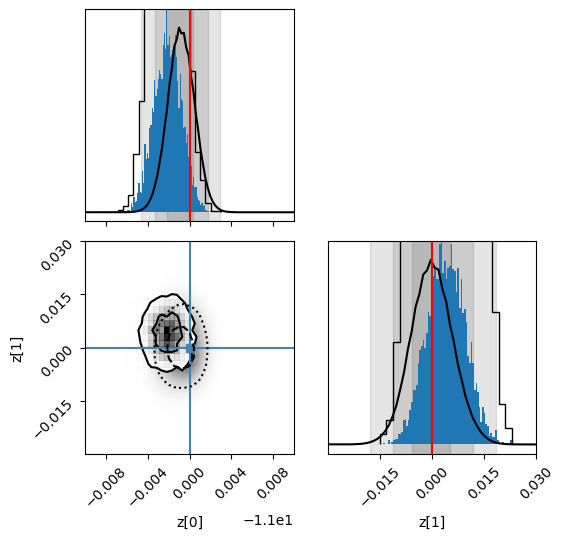

In [60]:
post_samples = sampler.get_chain(discard=100, thin=5, flat=True)[:, :2]
fig = corner.corner(
    post_samples, 
    normed=True,
    truths=target_z[:2], levels=[1-np.exp(-0.5), 1-np.exp(-2)]
)
swyft.plot_corner(lrs_total, parnames=lrs_total.parnames[0], fig=plt.gcf(), bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2)], smooth=1.0)
lims = [[-11.01, -10.99], [-0.03, 0.03]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(target_z[j], c="r")
    plt.hist(sampler.get_chain(discard=100, thin=10, flat=True)[:, j], bins=80, density=True)
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])